# Taxi Demand Prediction - New York City

## Business/Real World Problem
For a given location in New York City, our goal is to <b>predict the number of pickups in that given location</b>. Some location require more taxis at a particular time than other locations owing to the presence schools, hospitals, offices etc. The prediction result can be transferred to the taxi drivers via Smartphone app, and they can subsequently move to the locations where predicted pickups are high.

## Objectives & Constraints
<b>Objectives:</b> Our objective is to predict the number of pickups as accurately as possible for each region in a 10min interval. We will break up the whole New York City into regions. Now, the 10min interval is chosen because in NYC one can commute 1 mile in approximately 10 minutes given the traffic is normal at that particular time.<br><br>
<b>Constraints:</b>
* <b>Latency:</b> Given a location and current time of a taxi driver, as a taxi driver, he/she excepts to get the predicted pickups in his/her region and the adjoining regions in few seconds. Hence, there is a medium latency requirement.<br><br>

* <b>Interpretability:</b> As long as taxi driver gets good prediction result, he/she is not be much interested in the interpretability of the result. He/she is not much interested in why he/she is getting this result. Hence, there is a no interpretability required.<br><br>

* <b>Relative Errors:</b> Mean Absolute Percentage Error will be the relative error we will consider. Let say the predicted pickups for a particular location are 100, but actual pickups are 102, the percentage error will be 2% and Absolute error is 2. The taxi driver will be more interested in the percentage error than the absolute error. Let say in some region the predicted pickups are 250, and if taxi driver knows that the relative error is 10% then he/she will consider the predicted result to be in the range of 225 to 275, which is considerable.<br><br>

<b>Our goal is to reduce the percentage error is low as possible.</b> 

# 1. Data Information
<b>Source of Data:</b> Data can be downloaded from here:<br>
http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml.<br> 
Here, we have used Jan- 2015 and Jan- 2016 data.

## Data Collection

We have collected all yellow taxi trips data of Jan-2015 and Jan-2016(Will be using only Jan 2015 data)

<table>
    <tr>
        <th>File-Name</th>
        <th>File-Size</th>
        <th>Number of Records</th>
        <th>Number of Features</th>
        </tr>
    <tr>
        <td> yellow_tripdata_2015-01</td>
        <td> 1.84GB</td>
        <td> 12748986</td>
        <td> 19 </td>
    </tr>
    <tr>
        <td> yellow_tripdata_2016-01</td>
        <td> 1.59GB</td>
        <td> 10906858</td>
        <td> 19 </td>
    </tr>

## Information on Taxis

<b>Information on taxis:</b><br>
* <b>Yellow Taxi:</b> Yellow Medallion Taxicabs<br>
These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.<br><br>
* <b>For Hire Vehicles (FHVs)</b><br> 
FHV transportation is accessed by a pre-arrangement with a dispatcher or limo company. These FHVs are not permitted to pick up passengers via street hails, as those rides are not considered pre-arranged.<br><br>
* <b>Green Taxi: Street Hail Livery (SHL)</b><br> 
The SHL program will allow livery vehicle owners to license and outfit their vehicles with green borough taxi branding, meters, credit card machines, and ultimately the right to accept street hails in addition to pre-arranged rides.<br><br>
<b>In this project we are considering only the yellow taxis for the time period of Jan 2015. We have used Jan- 2015 data to make prediction for Jan- 2016 data.</b>

In [178]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import gpxpy.geo
from datetime import datetime as datetime
import time
import seaborn as sns
import os
import math
import xgboost as xgb
import matplotlib
matplotlib.use('nbagg')
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
import graphviz

##os.environ["PATH"]= open(r"C:\Users\Sourav Dey\anaconda3\envs\Capstone\Lib\site-packages\graphviz")

warnings.simplefilter('ignore')


In [179]:
data_2015 = dd.read_csv(r"C:\Users\Sourav Dey\Desktop\Taxi-Demand-Prediction-New-York-City-master\yellow_tripdata_2015-01.csv")

In [180]:
data_2015.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

In [181]:
data_2015.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [182]:
print("Number of columns = "+str(len(data_2015.columns)))

Number of columns = 19


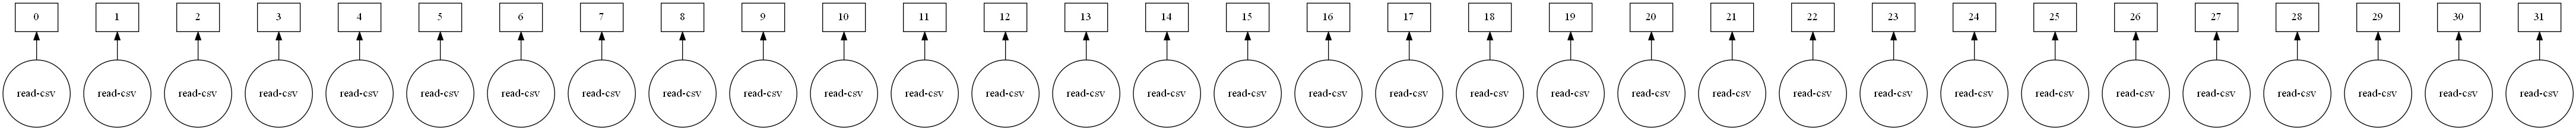

In [183]:
data_2015.visualize()


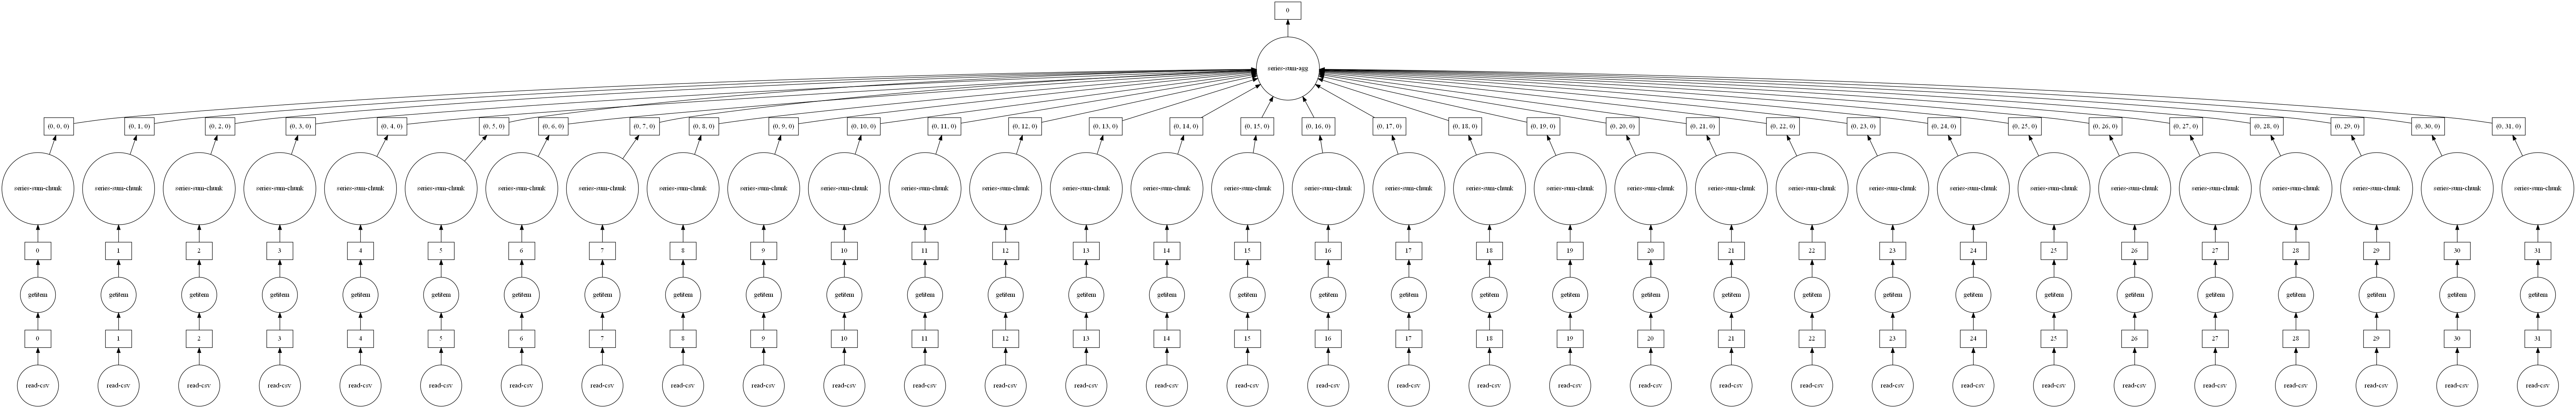

In [184]:
data_2015["passenger_count"].sum().visualize()

In [185]:
print("Total Number of Passengers in January 2015 = "+str(data_2015["passenger_count"].sum(axis = 0).compute()))


Total Number of Passengers in January 2015 = 21437303


## Features in Dataset
<table>
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>

	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

In [186]:
print("Number of nan values = {}".format(data_2015.isnull().sum().compute()))

Number of nan values = VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    3
total_amount             0
dtype: int64


Since we will not be using "improvement_surcharge" in our task, so nan values will not affect us. So, we are leaving it as it is.

## Problem Formulation: Time Series Forecasting

Given a region and a 10min interval, we have to predict pickups.
* (a): How to break up the NYC into regions?
* (b): Every region of NYC has to be broken up into 10min  interval.<br>

Now, every row pickup has longitude and latitude in it, and we will use this to define pickup regions. 
We already know, about the pickup at time 't', we will predict the pickup at time 't+1' in the same region. Hence, this problem can be thought of as a 'Time Series Prediction' problem. It is a special case of regression problems. In short, we will use the data at time 't' to predict for time 't+1'.

## Performance Metric
* 1) Mean Absolute Percentage Error(MAPE)
* 2) Mean Squared Error(MSE)

# 2. Univariate Analysis & Data Cleaning
Here, we will do the univariate analysis of the data and remove all the erroneous/outlier points.

## Latitude and Longitude
It is inferred from the source: https://www.flickr.com/places/info/2459115 that New York is bounded by the location coordinates(latitude, longitude) - (40.5774, -74.15) & (40.9176,-73.7004) hence any coordinates--including both pickups and drop-offs--not within these coordinates are not considered by us as we are only concerned with pickups which originate within New York. 

### Pickup 

In [187]:
#detecting the pickups latitude and longitudes which are outside NYC.
outside_NYC = data_2015[((data_2015.pickup_latitude <= 40.5774) | (data_2015.pickup_longitude <= -74.15) | (data_2015.pickup_latitude >= 40.9176) | (data_2015.pickup_longitude >= -73.7004))]
#latitude at equator is 0. Above equator latitude increases and becomes 90 at north pole. Below equator latitude decreases and
#is negative and becomes -90 at south pole.
#Longitude is 0 at United Kingdom(UK). To the right of UK, longitude increases positively and to the left of UK longitude decrease
#and is negative.

m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

outside_pickups = outside_NYC.head(25000)

for i,j in outside_pickups.iterrows():
    if j["pickup_latitude"] != 0:
        folium.Marker([j["pickup_latitude"], j["pickup_longitude"]]).add_to(m)
m

<b>Observation:</b>As you can see in the above map, there are many erroneous data points, which are in some other state, and some of them are even in Atlantic Ocean. All these erroneous data points will also be removed as a part of data cleaning process.

### Dropoff

In [188]:
#detecting the dropoff latitude and longitudes which are outside NYC.
outside_NYC = data_2015[((data_2015.dropoff_latitude <= 40.5774) | (data_2015.dropoff_longitude <= -74.15) | (data_2015.dropoff_latitude >= 40.9176) | (data_2015.dropoff_longitude >= -73.7004))]
#latitude at equator is 0. Above equator latitude increases and becomes 90 at north pole. Below equator latitude decreases and
#is negative and becomes -90 at south pole.
#Longitude is 0 at United Kingdom(UK). To the right of UK, longitude increases positively and to the left of UK longitude decrease
#and is negative.

m = folium.Map(location = [40.5774, -73.7004], tiles = "Stamen Toner")

outside_dropoff = outside_NYC.head(25000)

for i,j in outside_dropoff.iterrows():
    if j["dropoff_latitude"] != 0:
        folium.Marker([j["dropoff_latitude"], j["dropoff_longitude"]]).add_to(m)
m
#documentation of folium: https://python-visualization.github.io/folium/docs-v0.6.0/quickstart.html#Getting-Started

<b>Observation:</b>As you can see in the above map, there are many erroneous data points, which are in some other state, and some of them are even in Atlantic Ocean. All these erroneous data points will also be removed as a part of data cleaning process.

### Creating new Dataframe with Trip duration and speed

In [189]:
def timeToUnix(t):
    #we have a time in the format "YYYY-MM-DD HH:MM:SS", which is a string
    change = datetime.strptime(t, "%Y-%m-%d %H:%M:%S") #this will convert the String time into datetime format
    t_tuple = change.timetuple() #this will convert the datetime formatted time into structured time
    return time.mktime(t_tuple) + 3600  #this will convert structured time into unix-time.
    #Now why, I have added 3600 in the above unix times. NOW, UNIX TIMESTAMP MEANS HOW MANY SECONDS HAVE ELAPSED SINCE 1 JAN 1970
    #(EPOCH) CALCULATED FROM THE REFERENCE OF GMT. I HAVE MADE THIS PROJECT IN GERMANY WHICH IS 1HR/3600SECS AHEAD OF GMT TIME, 
    #AND HERE "time.mktime()" FUNCTION RETURNS UNIX TIMESTAMP FROM THE REFERENCE OF LOCAL TIME. SO, THEREFORE, IN ORDER TO 
    #COMPENSATE FOR 1HR AHEAD, "time.mktime" SUBTRACTED 3600 SECONDS MEANS 1HR FROM UNIX TIME STAMP IN ORDER TO CATER TO 
    #LOCAL TIME. SO, THEREFORE, IF WE WANT OUR UNIX TIME TO BE EXACTLY EQUAL TO GMT TIME, WE HAVE TO ADD 3600 SECONDS 
    #MEANS 1HR TO UNIX TIME. lET SAY AT 12:00AM ON 1st JAN 1970, TIME ELAPSED AT GMT IS 0, THE TIME ELAPSED IN GERMANY IS 
    #3600SEC. NOW ON 1st JAN 2015, ELASPED SECONDS AT GMT IS 'X', SO THE EQUIVALENT ELAPSED SECONDS IN GERMANY WILL BE X+3600. 
    #NOW "time.mktime()" SUBTRACT THIS 3600 EXTRA IN GERMAN TIME WHICH WE HAVE TO ADD IN ORDER TO MAKE IT EQUAL TO GMT.

def dfWithTripTimes(df):
    startTime = datetime.now()
    duration = df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].compute()
    pickup_time = [timeToUnix(pkup) for pkup in duration["tpep_pickup_datetime"].values]
    dropoff_time = [timeToUnix(drpof) for drpof in duration["tpep_dropoff_datetime"].values]
#     trip_duration = []
#     for xy in zip(dropoff_time, pickup_time):
#         trip_duration.append(xy[0] - xy[1])
    trip_duration = (np.array(dropoff_time) - np.array(pickup_time))/float(60)  #trip duration in minutes
    
    NewFrame = df[['passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount']].compute()
    NewFrame["trip_duration"] = trip_duration
    NewFrame["pickup_time"] = pickup_time
    NewFrame["speed"] = (NewFrame["trip_distance"]/NewFrame["trip_duration"])*60  #speed in miles/hr
    
    print("Time taken for creation of dataframe is {}".format(datetime.now() - startTime))
    return NewFrame

In [190]:
new_frame = dfWithTripTimes(data_2015)

Time taken for creation of dataframe is 0:06:07.654845


## Trip Durations

### According to NYC Taxi and Limousine Commission regulations, the maximum allowed trip duration in a 24hrs interval is 12 hrs.

<IPython.core.display.Javascript object>


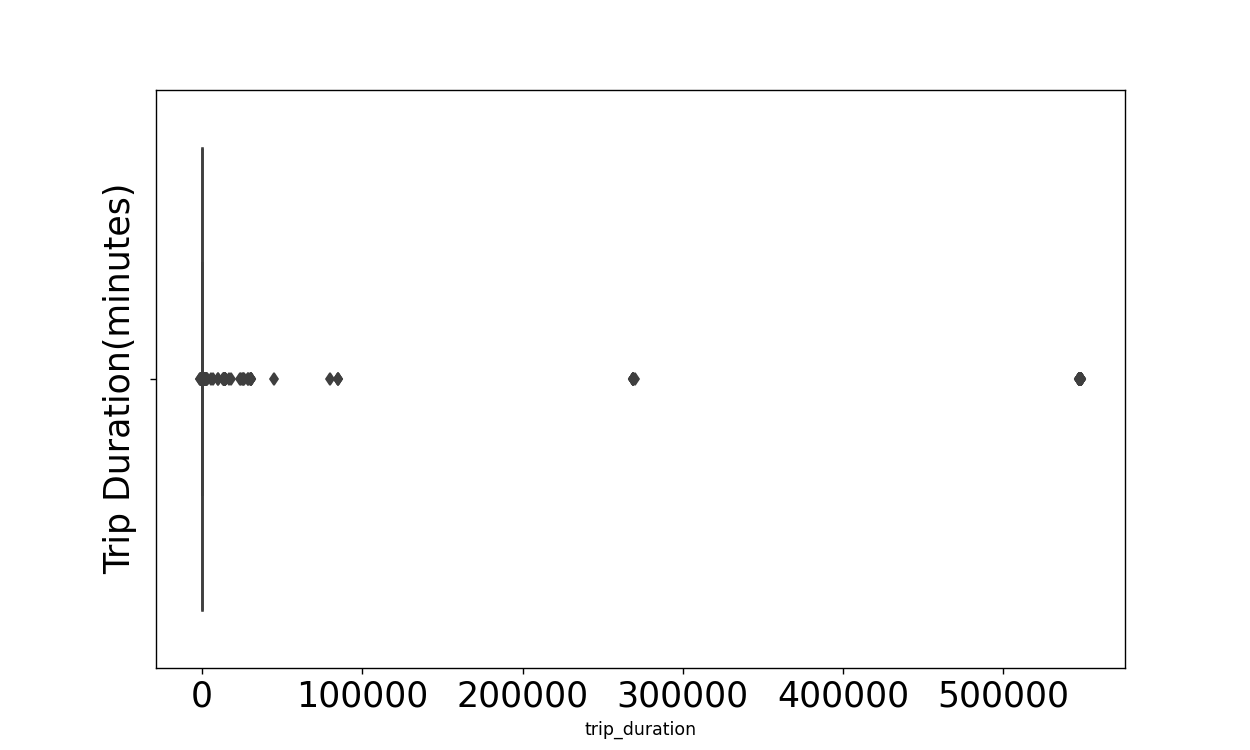

In [191]:
plt.figure(figsize = (10,6))
sns.boxplot("trip_duration", data = new_frame, orient = "v")
plt.tick_params(labelsize = 20)
plt.ylabel("Trip Duration(minutes)", fontsize = 20)
plt.show()

In [192]:
quantile_tripDuration = new_frame.trip_duration.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [193]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of Trip Duration is {}min".format((int(i*100)), quantile_tripDuration[i]))

0th percentile value of Trip Duration is -1211.0166666666667min
10th percentile value of Trip Duration is 3.8333333333333335min
20th percentile value of Trip Duration is 5.383333333333334min
30th percentile value of Trip Duration is 6.816666666666666min
40th percentile value of Trip Duration is 8.3min
50th percentile value of Trip Duration is 9.95min
60th percentile value of Trip Duration is 11.866666666666667min
70th percentile value of Trip Duration is 14.283333333333333min
80th percentile value of Trip Duration is 17.633333333333333min
90th percentile value of Trip Duration is 23.45min
100th percentile value of Trip Duration is 548555.6333333333min


In [194]:
qValues = np.round(np.arange(0.90, 1.01, 0.01), 2)
for i in qValues:
    print("{} percentile value of Trip Duration is {}min".format((int(i*100)), quantile_tripDuration[i]))

90 percentile value of Trip Duration is 23.45min
91 percentile value of Trip Duration is 24.35min
92 percentile value of Trip Duration is 25.383333333333333min
93 percentile value of Trip Duration is 26.55min
94 percentile value of Trip Duration is 27.933333333333334min
95 percentile value of Trip Duration is 29.583333333333332min
96 percentile value of Trip Duration is 31.68333333333333min
97 percentile value of Trip Duration is 34.46666666666667min
98 percentile value of Trip Duration is 38.71666666666667min
99 percentile value of Trip Duration is 46.75min
100 percentile value of Trip Duration is 548555.6333333333min


<b>Observations:</b>Here, 0th percentile value of trip duration is negative(weird), also 99th percentile value of trip duration is 46.75min, but 100th percentile value is 548555.633min(weird). 0th and 100th percentile values are certainly an erroneous points.

In [195]:
new_frame_cleaned = new_frame[(new_frame.trip_duration>1) & (new_frame.trip_duration<720)]

#### Plot after removing outliers and erroneous points

<IPython.core.display.Javascript object>


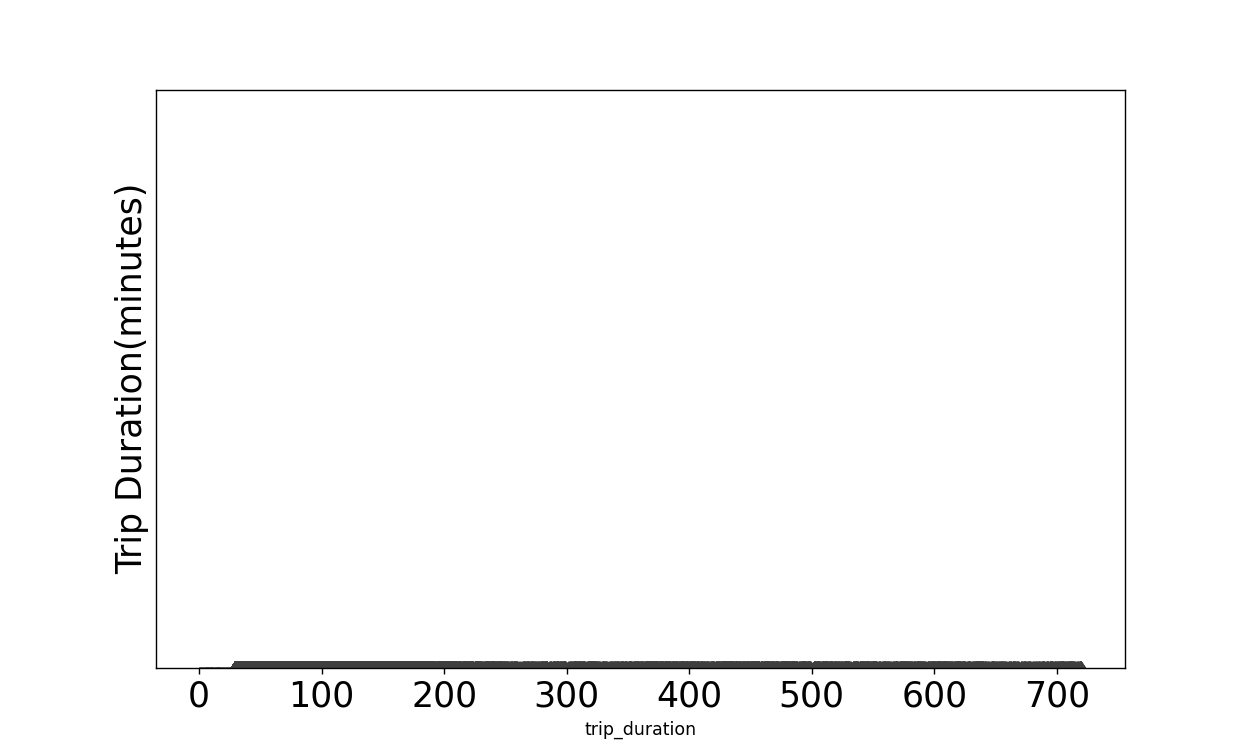

In [196]:
plt.figure(figsize = (10,6))
sns.boxplot("trip_duration", data = new_frame_cleaned, orient = "v")
plt.ylim(ymin = 1, ymax = 750)
plt.tick_params(labelsize = 20)
plt.ylabel("Trip Duration(minutes)", fontsize = 20)
plt.show()

<IPython.core.display.Javascript object>


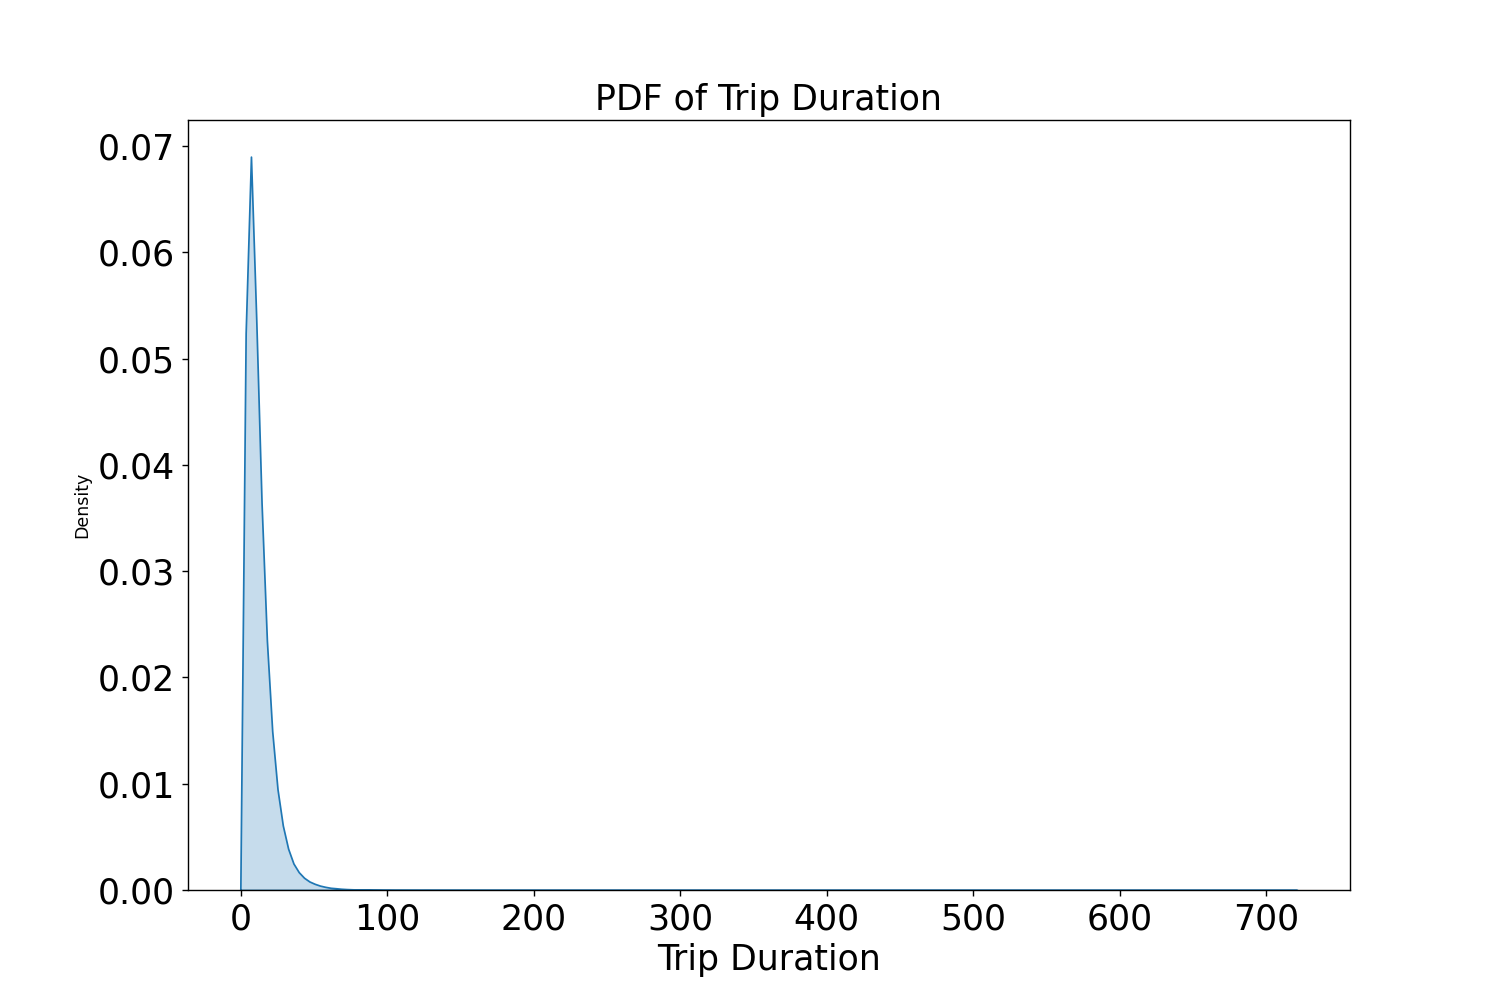

In [197]:
plt.figure(figsize = (12,8))
sns.kdeplot(new_frame_cleaned["trip_duration"].values, shade = True, cumulative = False)
plt.tick_params(labelsize = 20)
plt.xlabel("Trip Duration", fontsize = 20)
plt.title("PDF of Trip Duration", fontsize = 20)
plt.show()

<b>Observation:</b> Above PDF plot shows that almost all of the trip durations are very less and approximately less than 100, extremely few trip durations are above 100.

## Speed

In [200]:
def changingLabels(num):
    if num < 10**3:
        return num
    elif num>=10**3 and num < 10**6:
        return str(num/10**3)+"k"
    elif num>=10**6 and num < 10**9:
        return str(num/10**6) + "M"
    else:
        return str(num/10**9) + "B"

<IPython.core.display.Javascript object>


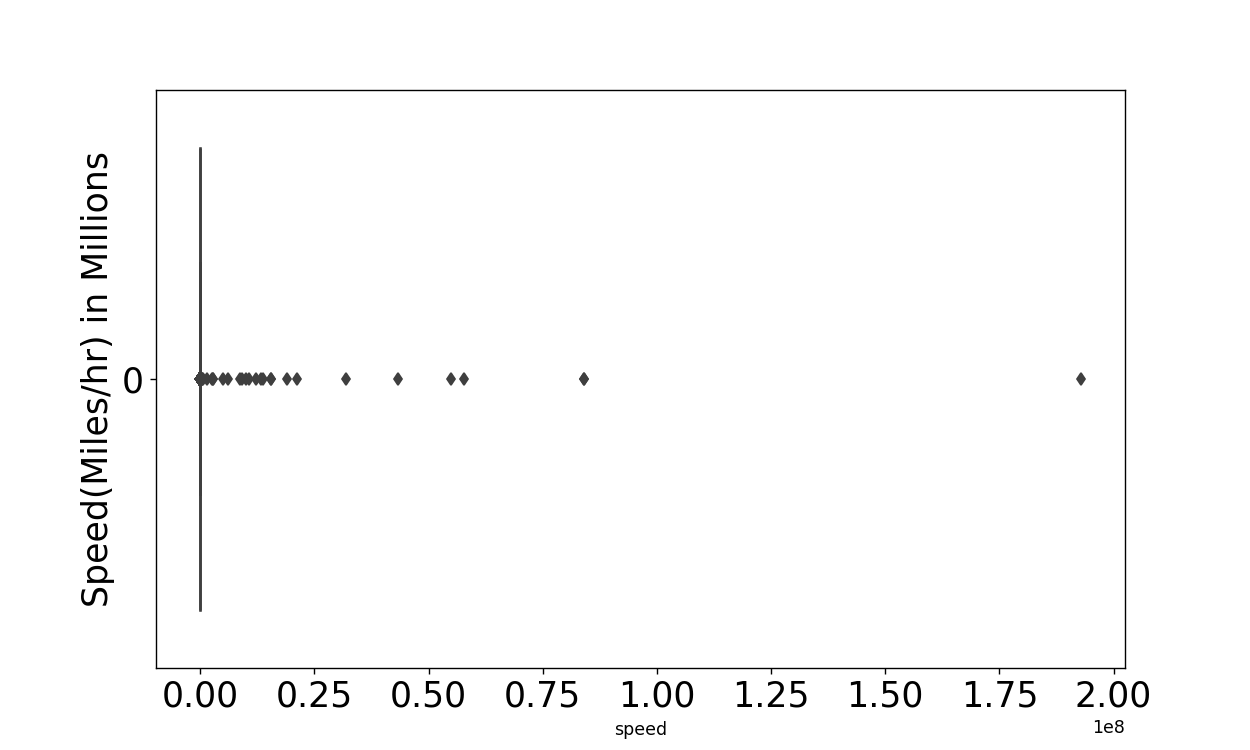

In [201]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("speed", data = new_frame_cleaned, orient = "v")

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
plt.tick_params(labelsize = 20)
plt.ylabel("Speed(Miles/hr) in Millions", fontsize = 20)
plt.show()

In [202]:
quantile_speed = new_frame_cleaned.speed.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [203]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 4)
for i in qValues:
    print("{}th percentile value of speed is {}miles/hr".format(int(i*100), quantile_speed[i]))

0th percentile value of speed is 0.0miles/hr
10th percentile value of speed is 6.409495548961425miles/hr
20th percentile value of speed is 7.80952380952381miles/hr
30th percentile value of speed is 8.929133858267717miles/hr
40th percentile value of speed is 9.98019801980198miles/hr
50th percentile value of speed is 11.06865671641791miles/hr
60th percentile value of speed is 12.286689419795222miles/hr
70th percentile value of speed is 13.796407185628745miles/hr
80th percentile value of speed is 15.963224893917962miles/hr
90th percentile value of speed is 20.186915887850468miles/hr
100th percentile value of speed is 192857142.85714284miles/hr


In [204]:
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print("{} percentile value of speed is {}miles/hr".format(int(i*100), quantile_speed[i]))

91 percentile value of speed is 20.916454400875093miles/hr
92 percentile value of speed is 21.752988047808763miles/hr
93 percentile value of speed is 22.721893491124263miles/hr
94 percentile value of speed is 23.844155844155843miles/hr
95 percentile value of speed is 25.182552504038775miles/hr
96 percentile value of speed is 26.80851063829787miles/hr
97 percentile value of speed is 28.84304932735426miles/hr
98 percentile value of speed is 31.591128254580514miles/hr
99 percentile value of speed is 35.75135055113604miles/hr
100 percentile value of speed is 192857142.85714284miles/hr


In [205]:
qValues = np.round(np.arange(0.991, 1.001, 0.001), 4)
quantile_speed = new_frame_cleaned.speed.quantile(qValues)
for i in qValues:
    print("{} percentile value of speed is {}miles/hr".format((i*100), quantile_speed[i]))

99.1 percentile value of speed is 36.31081290376664miles/hr
99.2 percentile value of speed is 36.91470054446461miles/hr
99.3 percentile value of speed is 37.588235294117645miles/hr
99.4 percentile value of speed is 38.330334294788756miles/hr
99.5 percentile value of speed is 39.17580011612381miles/hr
99.6 percentile value of speed is 40.15384615384615miles/hr
99.7 percentile value of speed is 41.338029086798095miles/hr
99.8 percentile value of speed is 42.866243893093184miles/hr
99.9 percentile value of speed is 45.310675074725154miles/hr
100.0 percentile value of speed is 192857142.85714284miles/hr


<b>Observations:</b> Here, 100th percentile value of a speed is 192 Million miles/hr which is (BIZZARE). Furthermore, 99.9th percentile value of speed is 45.31miles/hr. So, we are removing all the data points where speed is greater than 45.31miles/hr.

In [206]:
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.speed>0) & (new_frame_cleaned.speed<45.31)]

#### Box plot of speed after removing outliers and erroneous points.

<IPython.core.display.Javascript object>


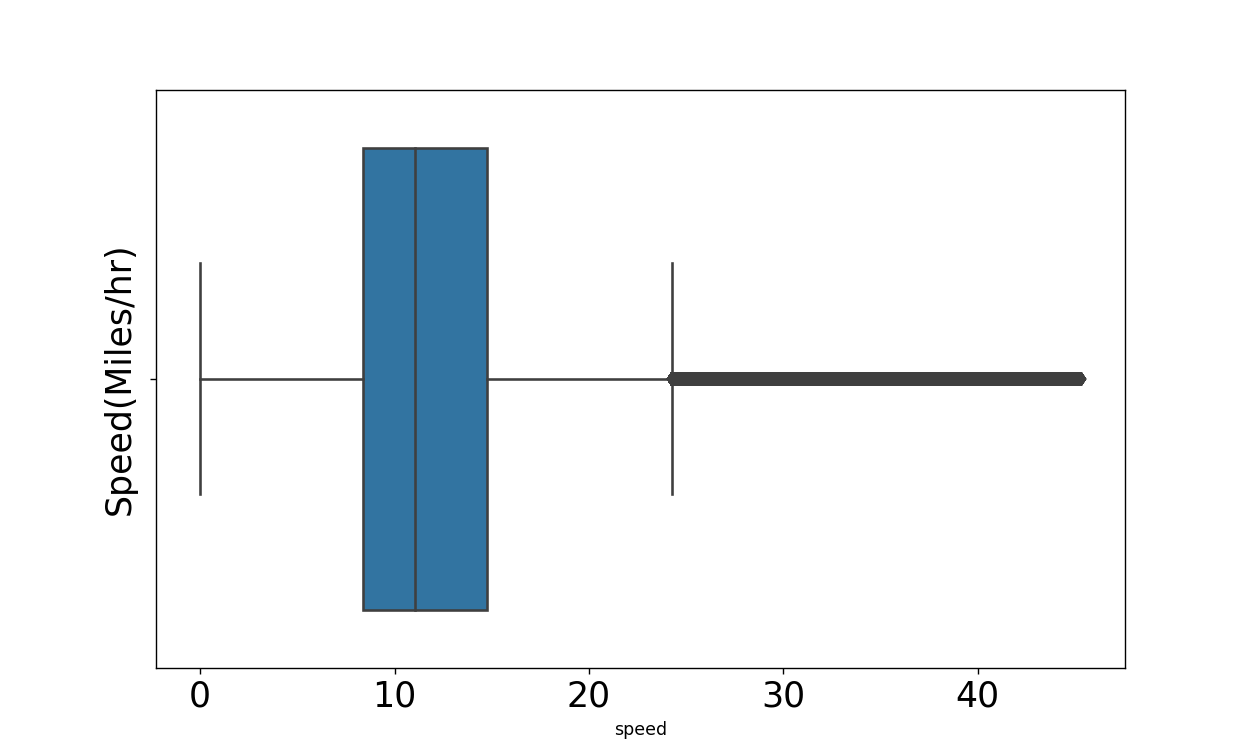

In [207]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("speed", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Speed(Miles/hr)", fontsize = 20)
plt.show()

In [210]:
Average_speed = sum(new_frame_cleaned.speed)/len(new_frame_cleaned.speed)
print("Average Speed of Taxis around NYC = "+str(Average_speed))

Average Speed of Taxis around NYC = 12.452320837813998


In [211]:
print("Speed of Taxis around NYC per 10 minutes = "+str(Average_speed/6)+" per 10 minutes.")

Speed of Taxis around NYC per 10 minutes = 2.075386806302333 per 10 minutes.


### The avg speed in Newyork speed is 12.45miles/hr, so a cab driver can travel 2 miles per 10min on avg.

## Trip Distance

<IPython.core.display.Javascript object>


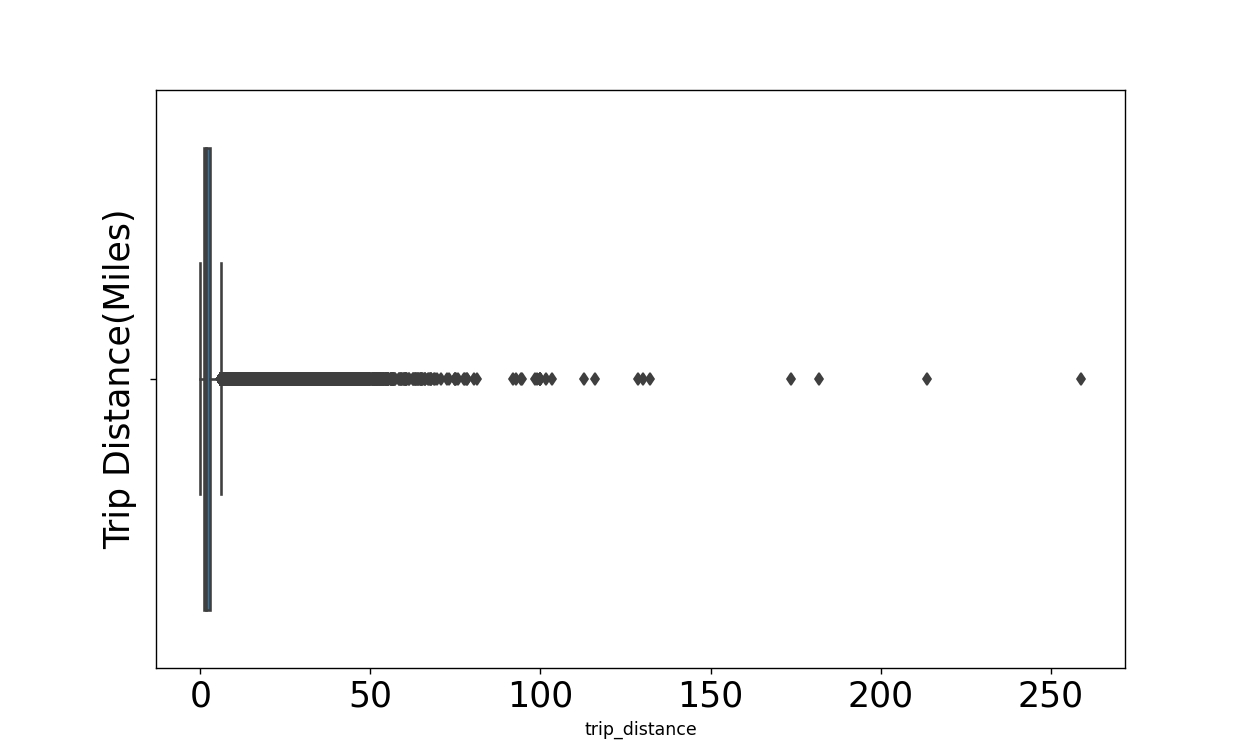

In [212]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("trip_distance", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Distance(Miles)", fontsize = 20)
plt.show()

In [213]:
quantile_tripDistance = new_frame_cleaned.trip_distance.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [214]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of trip distance is {}miles".format(int(i*100), quantile_tripDistance[i]))

0th percentile value of trip distance is 0.01miles
10th percentile value of trip distance is 0.67miles
20th percentile value of trip distance is 0.9000000000000001miles
30th percentile value of trip distance is 1.1miles
40th percentile value of trip distance is 1.39miles
50th percentile value of trip distance is 1.7miles
60th percentile value of trip distance is 2.08miles
70th percentile value of trip distance is 2.61miles
80th percentile value of trip distance is 3.6miles
90th percentile value of trip distance is 5.98miles
100th percentile value of trip distance is 258.9miles


In [215]:
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print("{} percentile value of trip distance is {}miles".format(int(i*100), quantile_tripDistance[i]))

91 percentile value of trip distance is 6.469999999999999miles
92 percentile value of trip distance is 7.09miles
93 percentile value of trip distance is 7.87miles
94 percentile value of trip distance is 8.739999999999998miles
95 percentile value of trip distance is 9.6miles
96 percentile value of trip distance is 10.6miles
97 percentile value of trip distance is 12.1miles
98 percentile value of trip distance is 16.06miles
99 percentile value of trip distance is 18.18miles
100 percentile value of trip distance is 258.9miles


In [216]:
quantile_tripDistance = new_frame_cleaned.trip_distance.quantile(np.round(np.arange(0.991, 1.001, 0.001), 4))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} percentile value of trip distance is {}miles".format((i*100), quantile_tripDistance[i]))

99.1 percentile value of trip distance is 18.37miles
99.2 percentile value of trip distance is 18.6miles
99.3 percentile value of trip distance is 18.84miles
99.4 percentile value of trip distance is 19.14miles
99.5 percentile value of trip distance is 19.5miles
99.6 percentile value of trip distance is 19.97miles
99.7 percentile value of trip distance is 20.51miles
99.8 percentile value of trip distance is 21.23miles
99.9 percentile value of trip distance is 22.58miles
100.0 percentile value of trip distance is 258.9miles


<b>Observation:</b> Here, 99.9th percentile of trip distance is 22.58miles, however, 100th percentile value is 258.9miles, which is very high. So, we are removing all the data points where trip distance is greater than 23miles.

In [217]:
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.trip_distance>0) & (new_frame_cleaned.trip_distance<23)]

<IPython.core.display.Javascript object>


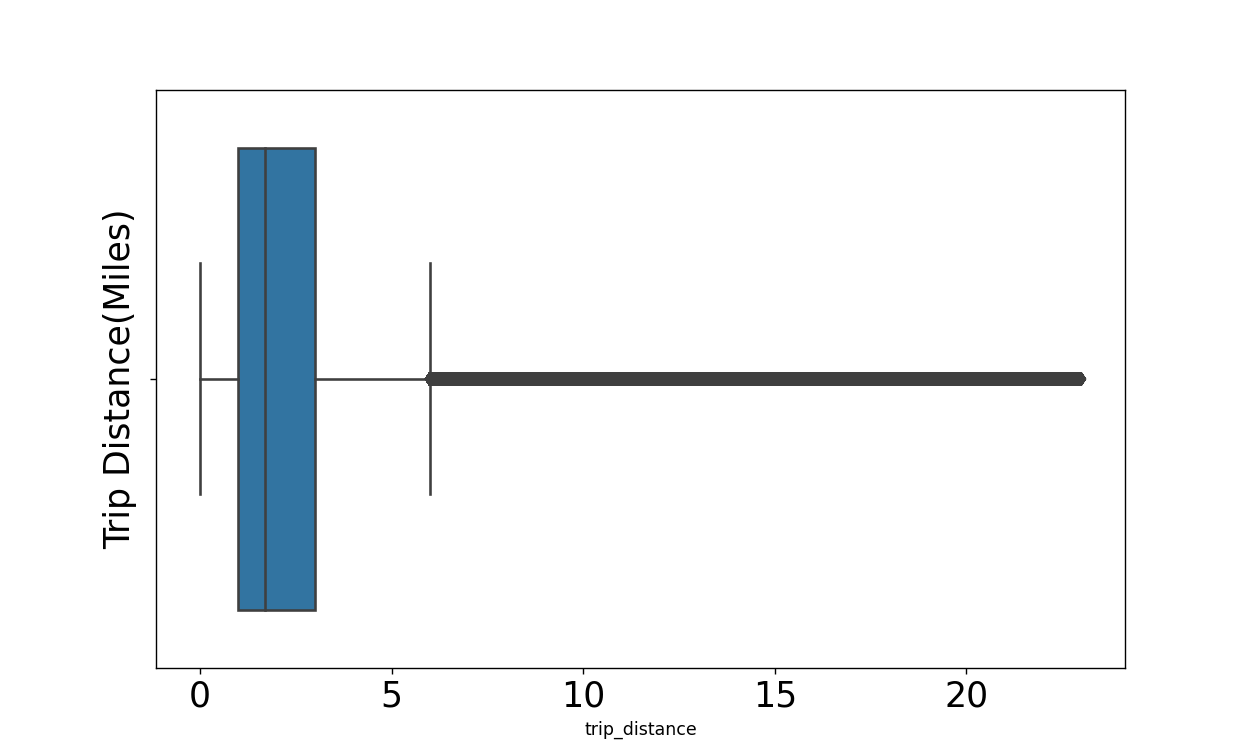

In [218]:
#plot of trip distance after removing outlier points
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("trip_distance", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Distance(Miles)", fontsize = 20)
plt.show()

## Total Fare

<IPython.core.display.Javascript object>


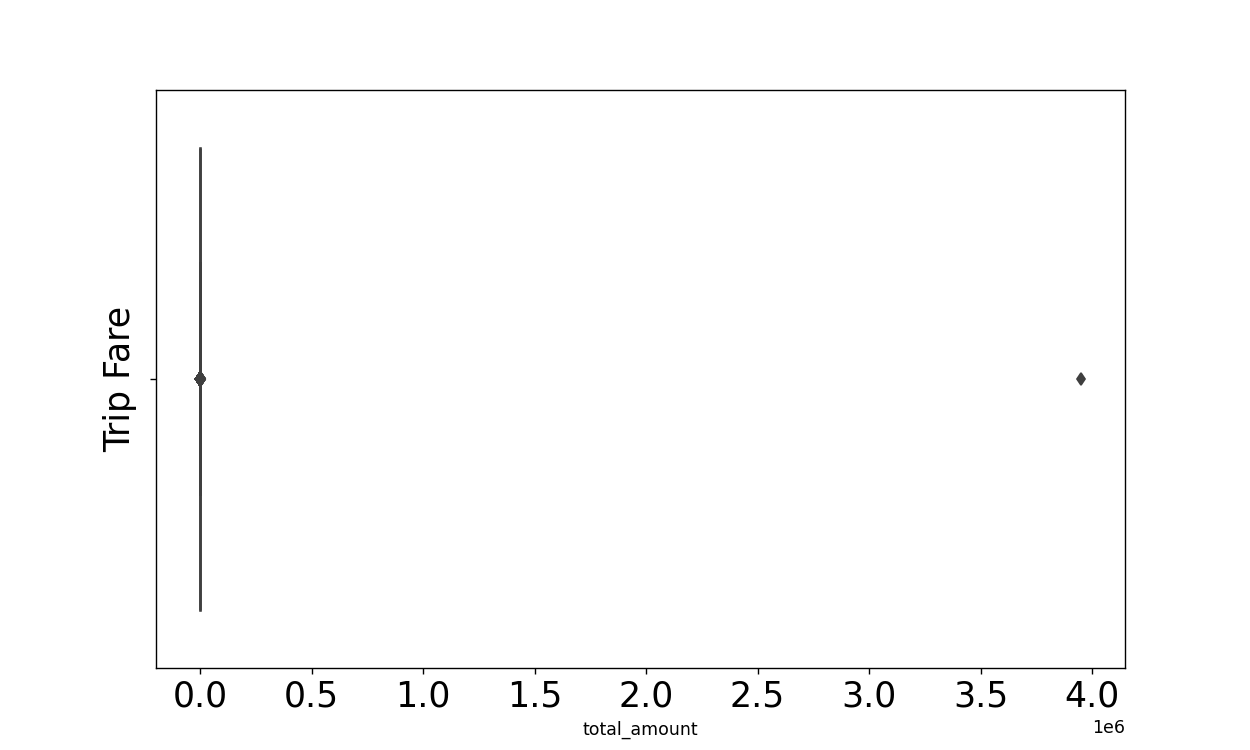

In [219]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("total_amount", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Fare", fontsize = 20)
plt.show()

In [220]:
quantile_totalAmount = new_frame_cleaned.total_amount.quantile(np.round(np.arange(0.00, 1.01, 0.01), 2))

In [221]:
qValues = np.round(np.arange(0.00, 1.01, 0.1), 2)
for i in qValues:
    print("{}th percentile value of trip fare is {}".format(int(i*100), quantile_totalAmount[i]))

0th percentile value of trip fare is -242.55
10th percentile value of trip fare is 6.35
20th percentile value of trip fare is 7.799999999999999
30th percentile value of trip fare is 8.8
40th percentile value of trip fare is 9.8
50th percentile value of trip fare is 11.16
60th percentile value of trip fare is 12.8
70th percentile value of trip fare is 14.8
80th percentile value of trip fare is 18.3
90th percentile value of trip fare is 25.8
100th percentile value of trip fare is 3950611.6


In [222]:
qValues = np.round(np.arange(0.91, 1.01, 0.01), 3)
for i in qValues:
    print("{} percentile value of trip fare is {}".format(int(i*100), quantile_totalAmount[i]))

91 percentile value of trip fare is 27.3
92 percentile value of trip fare is 29.13
93 percentile value of trip fare is 31.549999999999997
94 percentile value of trip fare is 34.63
95 percentile value of trip fare is 38.13
96 percentile value of trip fare is 42.13
97 percentile value of trip fare is 47.53
98 percentile value of trip fare is 57.68
99 percentile value of trip fare is 65.8
100 percentile value of trip fare is 3950611.6


In [223]:
quantile_totalAmount = new_frame_cleaned.total_amount.quantile(np.round(np.arange(0.991, 1.001, 0.001), 3))
qValues = np.round(np.arange(0.991, 1.001, 0.001), 3)
for i in qValues:
    print("{} percentile value of trip fare is {}".format((i*100), quantile_totalAmount[i]))

99.1 percentile value of trip fare is 67.55
99.2 percentile value of trip fare is 68.8
99.3 percentile value of trip fare is 69.6
99.4 percentile value of trip fare is 69.73
99.5 percentile value of trip fare is 69.73
99.6 percentile value of trip fare is 69.76
99.7 percentile value of trip fare is 72.46
99.8 percentile value of trip fare is 75.16
99.9 percentile value of trip fare is 86.6
100.0 percentile value of trip fare is 3950611.6


<b>Observation:</b>Here, 99.9th percentile fare amount of a trip is 86.6. However, 100th percentile of a fare amount is 3Million which is bizzare. Therefore, we have removedall the data points where fare amount is more than 99.9th percentile value.

In [85]:
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.total_amount>0) & (new_frame_cleaned.total_amount<86.6)]

<IPython.core.display.Javascript object>


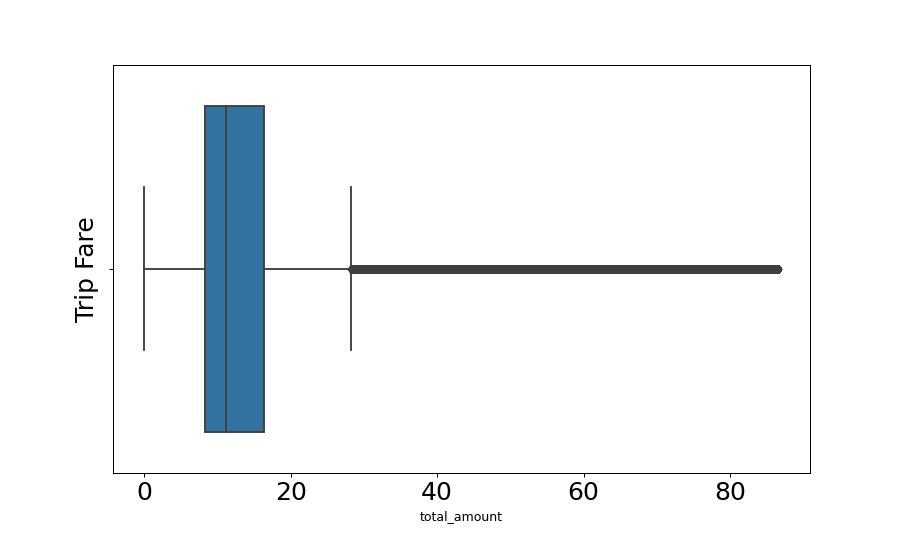

In [86]:
#plot of fare amount after removing outliers and erroneous points
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("total_amount", data = new_frame_cleaned, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Fare", fontsize = 20)
plt.show()

## Removing all the data points where pickup and drop-off are outside NYC

### Removing Pickups outside NYC

In [87]:
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.pickup_latitude >= 40.5774) & (new_frame_cleaned.pickup_latitude <= 40.9176)) & ((new_frame_cleaned.pickup_longitude >= -74.15) & (new_frame_cleaned.pickup_longitude <= -73.7004)))]

In [88]:
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

pickups_within_NYC = new_frame_cleaned.sample(n = 500)

for i,j in pickups_within_NYC.iterrows():
    folium.Marker([j["pickup_latitude"], j["pickup_longitude"]]).add_to(m)
m

<b>Observation:</b> Most of the pickups are concentrated in and around Manhattan district of New York

### Removing Dropoffs outside NYC

In [89]:
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.dropoff_latitude >= 40.5774) & (new_frame_cleaned.dropoff_latitude <= 40.9176)) & ((new_frame_cleaned.dropoff_longitude >= -74.15) & (new_frame_cleaned.dropoff_longitude <= -73.7004)))]

In [90]:
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

dropoff_within_NYC = new_frame_cleaned.sample(n = 500)

for i,j in dropoff_within_NYC.iterrows():
    folium.Marker([j["dropoff_latitude"], j["dropoff_longitude"]]).add_to(m)
m

<b>Observation:</b> Most of the dropoffs are concentrated in and around Manhattan district of New York

### Fraction of points left after removing all the erroneous points and outlier points. Points where pickups and dropoffs are outside of NYC are also removed.

In [91]:
print("Fraction of cleaned points",str(new_frame_cleaned.shape[0]/new_frame.shape[0]))

Fraction of cleaned points 0.9680387130396095


In [92]:
print("Total number of outliers and erroneous points removed = ",str(new_frame.shape[0] - new_frame_cleaned.shape[0]))

Total number of outliers and erroneous points removed =  407474


# 3. Data Preparation

## Clustering/Segmentation

In [93]:
coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
neighbors = []

def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = 100000  #any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
                #you can check the documentation of above "gpxpy.geo.haversine_distance" at "https://github.com/tkrajina/gpxpy/blob/master/gpxpy/geo.py"
                #"gpxpy.geo.haversine_distance" gives distance between two latitudes and longitudes in meters. So, we have to convert it into miles.
                distance = distance/(1.60934*1000)   #distance from meters to miles
                min_distance = min(min_distance, distance) #it will return minimum of "min_distance, distance".
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-"*10)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

In [94]:
startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time taken = "+str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 3.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 7.0
Minimum distance between any two clusters = 0.9129299771774434
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 5.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 15.0
Minimum distance between any two clusters = 0.4606293466090885
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 7.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 23.0
Minimum distance between any two clusters = 0.46188001137872287
----------
On choosing a cluster size of 40
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 10.0
Avg. Number clusters outside of vicinity where in

#### We want the minimum inter cluster distance between any two clusters to be less than 0.5miles and when number of clusters are 30 then this condition is almost meeting. Therefore, we are considering number of clusters to be 30.

The MiniBatchKMeans is a variant of the KMeans algorithm which uses mini-batches to reduce the computation time, while still attempting to optimise the same objective function. Mini-batches are subsets of the input data, randomly sampled in each training iteration. These mini-batches drastically reduce the amount of computation required to converge to a local solution. In contrast to other algorithms that reduce the convergence time of k-means, mini-batch k-means produces results that are generally only slightly worse than the standard algorithm.

In [95]:
coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
regions = MiniBatchKMeans(n_clusters = 30, batch_size = 10000).fit(coord)
new_frame_cleaned["pickup_cluster"] = regions.predict(new_frame_cleaned[["pickup_latitude", "pickup_longitude"]])

In [96]:
new_frame_cleaned.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_duration  \
0         -73.974785         40.750618         17.05      18.050000   
1         -73.994415         40.759109         17.80      19.833333   
2         -73.951820         40.824413         10.80      10.050000   
3         -74.004326         40.719986          4.80       1.866667   
4         -74.004181         40.742653         16.30      19.316667   

    pickup_time      speed  pickup_cluster  
0  1.421333e+09   5.285319              24  
1  1.420906e+09   9.983193              22  
2  1.420906e+09  10.746269              27  
3  1.420906e+09  16.071429               9  
4  1.420906e+09   9.318378              26

#### Plotting cluster centers

In [97]:
centerOfRegions = regions.cluster_centers_
noOfClusters = len(centerOfRegions)
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

for i in range(noOfClusters):
    folium.Marker([centerOfRegions[i][0], centerOfRegions[i][1]], popup = (str(np.round(centerOfRegions[i][0], 2))+", "+str(np.round(centerOfRegions[i][1], 2)))).add_to(m)
m

#### Plotting Regions in NYC

<IPython.core.display.Javascript object>


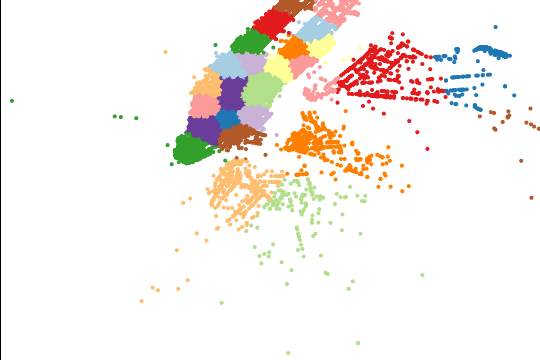

In [98]:
NYC_latitude_range = (40.5774, 40.9176)
NYC_Longitude_range = (-74.15, -73.7004)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = new_frame_cleaned.pickup_longitude.values[:70000], y = new_frame_cleaned.pickup_latitude.values[:70000], c = new_frame_cleaned.pickup_cluster.values[:70000], cmap = "Paired", s = 5)
ax.set_xlim(-74.10, -73.72)
ax.set_ylim(40.5774, 40.9176)
ax.set_title("Regions in New York City")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#Longitude values vary from left to right i.e., horizontally
#Latitude values vary from top to bottom means i.e., vertically

## Time Binning

In [99]:
# 1420070400 : 2015-01-01 00:00:00   (Equivalent unix time)
# 1451606400 : 2016-01-01 00:00:00   (Equivalent unix time)

def pickup_10min_bins(dataframe, month, year):
    pickupTime = dataframe["pickup_time"].values
    unixTime = [1420070400, 1451606400]
    unix_year = unixTime[year-2015]
    time_10min_bin = [int((i - unix_year)/600) for i in pickupTime]
    dataframe["time_bin"] = np.array(time_10min_bin)
    return dataframe

In [100]:
# In the above function we are just subtracting the pickup time from the unix time of 12:00AM 1st Jan 2015, and after that we 
# are dividing that with 600 in order to make a 10minute bin, that's it.
#For Jan 2016 data we are just subtracting its corresponding pickup time from the unix time of 12:00AM 1st Jan 2016.

In [101]:
jan_2015_data = pickup_10min_bins(new_frame_cleaned, 1, 2015)

In [102]:
jan_2015_data.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_duration  \
0         -73.974785         40.750618         17.05      18.050000   
1         -73.994415         40.759109         17.80      19.833333   
2         -73.951820         40.824413         10.80      10.050000   
3         -74.004326         40.719986          4.80       1.866667   
4         -74.004181         40.742653         16.30      19.316667   

    pickup_time      speed  pickup_cluster  time_bin  
0  1.421333e+09   5.285319              24      2103  
1  1.420906e+09   9.983193              22      1392  
2  1.420906e+09  10.746269              27      1392  
3  1.420906e+09  16.071429               9      1392  
4  1.420906e+09   9.318378              26      1392

In [103]:
print("There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015: ", str(len(np.unique(jan_2015_data["time_bin"]))))

There should be ((24*60)/10)*31 unique 10 minute time bins for the month of January 2015:  4464


In [104]:
jan_2015_timeBin_groupBy = jan_2015_data[["pickup_cluster", "time_bin", "trip_distance"]].groupby(by = ["pickup_cluster", "time_bin"]).count()

In [105]:
jan_2015_timeBin_groupBy.head()

trip_distance
pickup_cluster time_bin               
0              -26                 137
               -25                 292
               -24                 252
               -23                 211
               -22                 240

## Data Preparation for Januray 2016

In [106]:
# Up till now we cleaned data and prepared data for the month of Jan 2015.

# now doing the same operations for the month of Jan 2016.

# 1. Get the dataframe which includes only required colums.
# 2. Add trip_duration, speed, unix time stamp of pickup_time.
# 4. Remove the outliers based on trip_duration, speed, trip_distance, total_amount.
# 5. Remove all the points where pickup and dropoff are outside of New York City area.
# 6. Add pickup_cluster to each data point.
# 7. Add time_bin (index of 10min intravel to which that trip belongs to).
# 8. Group by data, based on 'pickup_cluster' and 'time_bin'
startTime = datetime.now()
frame_2016 = dd.read_csv(r"C:\Users\Sourav Dey\Desktop\Taxi-Demand-Prediction-New-York-City-master\yellow_tripdata_2016-01.csv")

print("PREPARATION OF JANUARY 2016 DATA.")
print("-"*35)

print("Number of columns = "+str(len(frame_2016.columns)))
print("-"*35)

new_frame2 = dfWithTripTimes(frame_2016)
print("New Frame for Jan 2016 creation done")
print("-"*35)

new_frame_cleaned2 = new_frame2[(new_frame2.trip_duration>1) & (new_frame2.trip_duration<720)]
print("Trip Duration Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(new_frame_cleaned2.speed>0) & (new_frame_cleaned2.speed<45.31)]
print("Speed Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(new_frame_cleaned2.trip_distance>0) & (new_frame_cleaned2.trip_distance<23)]
print("Trip Distance Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(new_frame_cleaned2.total_amount>0) & (new_frame_cleaned2.total_amount<86.6)]
print("Total Amount Outliers removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(((new_frame_cleaned2.pickup_latitude >= 40.5774) & (new_frame_cleaned2.pickup_latitude <= 40.9176)) & ((new_frame_cleaned2.pickup_longitude >= -74.15) & (new_frame_cleaned2.pickup_longitude <= -73.7004)))]
print("Pickups outside of NYC are removed")
print("-"*35)

new_frame_cleaned2 = new_frame_cleaned2[(((new_frame_cleaned2.dropoff_latitude >= 40.5774) & (new_frame_cleaned2.dropoff_latitude <= 40.9176)) & ((new_frame_cleaned2.dropoff_longitude >= -74.15) & (new_frame_cleaned2.dropoff_longitude <= -73.7004)))]
print("Dropoffs outside of NYC are removed")
print("-"*35)

new_frame_cleaned2["pickup_cluster"] = regions.predict(new_frame_cleaned2[["pickup_latitude", "pickup_longitude"]])
print("Pickup Clusters are assigned")
print("-"*35)

jan_2016_data = pickup_10min_bins(new_frame_cleaned2, 1, 2016)
print("Pickup time bins are assigned")
print("-"*35)

jan_2016_timeBin_groupBy = jan_2016_data[["pickup_cluster", "time_bin", "trip_distance"]].groupby(by = ["pickup_cluster", "time_bin"]).count()
print("Pickup cluster and time bins are grouped.")
print("-"*35)

print("Done...")
print("-"*35)

print("Fraction of Total data left = "+str(new_frame_cleaned2.shape[0]/new_frame2.shape[0]))
print("Total Number of outliers removed = "+str(new_frame2.shape[0] - new_frame_cleaned2.shape[0]))
print("-"*35)

print("Total Time taken for execution of Jan 2016 data = "+str(datetime.now() - startTime))
print("-"*35)

PREPARATION OF JANUARY 2016 DATA.
-----------------------------------
Number of columns = 19
-----------------------------------
Time taken for creation of dataframe is 0:04:49.229065
New Frame for Jan 2016 creation done
-----------------------------------
Trip Duration Outliers removed
-----------------------------------
Speed Outliers removed
-----------------------------------
Trip Distance Outliers removed
-----------------------------------
Total Amount Outliers removed
-----------------------------------
Pickups outside of NYC are removed
-----------------------------------
Dropoffs outside of NYC are removed
-----------------------------------
Pickup Clusters are assigned
-----------------------------------
Pickup time bins are assigned
-----------------------------------
Pickup cluster and time bins are grouped.
-----------------------------------
Done...
-----------------------------------
Fraction of Total data left = 0.9702401919966318
Total Number of outliers removed = 3245

In [107]:
jan_2016_data.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
5                2           5.52        -73.980118        40.743050   
6                2           7.45        -73.994057        40.719990   
7                1           1.20        -73.979424        40.744614   
8                1           6.00        -73.947151        40.791046   
9                1           3.21        -73.998344        40.723896   

   dropoff_longitude  dropoff_latitude  total_amount  trip_duration  \
5         -73.913490         40.763142          20.3          18.50   
6         -73.966362         40.789871          27.3          26.75   
7         -73.992035         40.753944          10.3          11.90   
8         -73.920769         40.865578          19.3          11.20   
9         -73.995850         40.688400          12.8          11.10   

    pickup_time      speed  pickup_cluster  time_bin  
5  1.451590e+09  17.902703               7       -27  
6  1.451590e+09  16.710280              29       -27  
7  1.451590e+09   6.050420               7       -26  
8  1.451590e+09  32.142857               2       -26  
9  1.451590e+09  17.351351              22       -26

In [108]:
jan_2016_timeBin_groupBy.head()

trip_distance
pickup_cluster time_bin               
0              -26                  99
               -25                 199
               -24                 209
               -23                 177
               -22                 198

In [109]:
jan_2015_data.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_duration  \
0         -73.974785         40.750618         17.05      18.050000   
1         -73.994415         40.759109         17.80      19.833333   
2         -73.951820         40.824413         10.80      10.050000   
3         -74.004326         40.719986          4.80       1.866667   
4         -74.004181         40.742653         16.30      19.316667   

    pickup_time      speed  pickup_cluster  time_bin  
0  1.421333e+09   5.285319              24      2103  
1  1.420906e+09   9.983193              22      1392  
2  1.420906e+09  10.746269              27      1392  
3  1.420906e+09  16.071429               9      1392  
4  1.420906e+09   9.318378              26      1392

In [110]:
jan_2015_timeBin_groupBy.head()

trip_distance
pickup_cluster time_bin               
0              -26                 137
               -25                 292
               -24                 252
               -23                 211
               -22                 240

## Smoothing

In [111]:
# Gets the unique time bins where pickup values are present for each region.

# for each cluster region we will collect all the indices of 10min intervals in which pickups happened.
# we got an observation that there are some time bins that doesn't have any pickups.

def getUniqueBinsWithPickups(dataframe):
    values = []
    for i in range(30):          #we have total 30 clusters
        cluster_id = dataframe[dataframe["pickup_cluster"] == i]
        unique_clus_id = list(set(cluster_id["time_bin"]))
        unique_clus_id.sort()   #inplace sorting
        values.append(unique_clus_id)
    return values
#this function is returning the indices of all the unique time_bins where there is a pickup for all the 30 clusters.

In [112]:
#now for Jan-2015, we have to find out, how many time_bins are there where there is no pickup in any of the cluster region
unique_binswithPickup_Jan_2015 = getUniqueBinsWithPickups(jan_2015_data)
for i in range(30):             #we have total 30 clusters
    print("For cluster ID {}, total number of time bins with no pickup in this clutser region is {}".format(i, (4464 - len(unique_binswithPickup_Jan_2015[i]))))
    print("-"*90)
#there are total 4464 time bins in Jan - 2015.
#"unique_binswithPickup_Jan_2015" contains all the unique time bins, where pickup happened. It contains 30 sub-arrays as there are 30 clusters
#and each sub-array contains the unique ID of all the time bins where pickup happened in the clusters which is the index of that sub-array.

For cluster ID 0, total number of time bins with no pickup in this clutser region is 31
------------------------------------------------------------------------------------------
For cluster ID 1, total number of time bins with no pickup in this clutser region is 148
------------------------------------------------------------------------------------------
For cluster ID 2, total number of time bins with no pickup in this clutser region is 28
------------------------------------------------------------------------------------------
For cluster ID 3, total number of time bins with no pickup in this clutser region is 44
------------------------------------------------------------------------------------------
For cluster ID 4, total number of time bins with no pickup in this clutser region is 62
------------------------------------------------------------------------------------------
For cluster ID 5, total number of time bins with no pickup in this clutser region is 29
----------------

There are two ways to fill up these values:

* Fill the missing value with 0's.

In [113]:
# Fill the missing value with 0's.
def fillMissingWithZero(numberOfPickups, correspondingTimeBin):
    ind = 0
    smoothed_regions = []
    for c in range(0, 30):
        smoothed_bins = []
        for t in range(4464):    #there are total 4464 time bins in both Jan-2015 & Feb-2016.
            if t in correspondingTimeBin[c]:   #if a time bin is present in "correspondingTimeBin" in cluster 'c', 
            #then it means there is a pickup, in this case, we are simply adding number of pickups, else we are adding 0.
                smoothed_bins.append(numberOfPickups[ind])
                ind += 1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions
#above function performs the operation in this way: if in any cluster if there is no pickup in any of the 4464 time bins, then 
#it simply appends 0 in that missing time_bin else it adds the original number of pickups in that time_bins.

* Fill the missing values with the avg values.

    * Case 1:(values missing at the start)<br>
      Ex1: _ _ _ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4)<br>
      Ex2: _ _ x => ceil(x/3), ceil(x/3), ceil(x/3)
      
    * Case 2:(values missing in middle)<br>
      Ex1: x _ _ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4)<br>
      Ex2: x _ _ _ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5)
      
    * Case 3:(values missing at the end)<br>
      Ex1: x _ _ _ => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4)<br> 
      Ex2: x _ => ceil(x/2), ceil(x/2)

In [114]:
def smoothing(numberOfPickups, correspondingTimeBin):
    ind = 0
    repeat = 0
    smoothed_region = []
    for cluster in range(0, 30):
        smoothed_bin = []
        for t1 in range(4464):
            if repeat != 0:   #this will ensure that we shall not fill the pickup values again which we already filled by smoothing
                repeat -= 1
            else:
                if t1 in correspondingTimeBin[cluster]:
                    smoothed_bin.append(numberOfPickups[ind])
                    ind += 1
                else:
                    if t1 == 0:           
    #<---------------------CASE-1:Pickups missing in the beginning------------------------>
                        for t2 in range(t1, 4464):
                            if t2 not in correspondingTimeBin[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                smoothed_value = (numberOfPickups[ind]*1.0)/((right_hand_limit + 1)*1.0)
                                for i in range(right_hand_limit + 1):
                                    smoothed_bin.append(math.ceil(smoothed_value))
                                ind += 1
                                repeat = right_hand_limit - t1
                                
                    if t1 != 0:
                        right_hand_limit = 0
                        for t2 in range(t1, 4464):
                            if t2 not in correspondingTimeBin[cluster]:
                                continue
                            else:
                                right_hand_limit = t2
                                break
                        if right_hand_limit == 0:
    #<---------------------CASE-2: Pickups MISSING IN THE END------------------------------>
                            smoothed_value = (numberOfPickups[ind-1]*1.0)/(((4464 - t1)+1)*1.0)
                            del smoothed_bin[-1]
                            for i in range((4464 - t1)+1):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            repeat = (4464 - t1) - 1    
    #<---------------------CASE-3: Pickups MISSING IN MIDDLE OF TWO VALUES----------------> 
                        else: 
                            smoothed_value = ((numberOfPickups[ind-1] + numberOfPickups[ind])*1.0)/(((right_hand_limit - t1)+2)*1.0)
                            del smoothed_bin[-1]
                            for i in range((right_hand_limit - t1)+2):
                                smoothed_bin.append(math.ceil(smoothed_value))
                            ind += 1
                            repeat = right_hand_limit - t1                        
        smoothed_region.extend(smoothed_bin)
    return smoothed_region

# when we multiply any integer with "1.0", then it will be converted into float.

In [115]:
# How above smoothing function code is working:
# Above smoothing function code is working on the goal of filling values with the following idea: 

# If there are no pickups in the beginning of time_bin means if the values are missing at time bins starting from 12:00 till 
# anytime, then we will fill pickups as follows:

# Case 1:(pickups missing at the start):
# Ex1: _ _ _ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4)
# Ex2: _ _ x => ceil(x/3), ceil(x/3), ceil(x/3)

# Case 2:(pickups missing at the end)
# Ex1: x _ _ _ => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4)
# Ex2: x _ => ceil(x/2), ceil(x/2)

# Case 3:(values missing in middle)
# Ex1: x _ _ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4)
# Ex2: x _ _ _ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5)

In [116]:
jan_2015_fillZero = fillMissingWithZero(jan_2015_timeBin_groupBy["trip_distance"].values, unique_binswithPickup_Jan_2015)
# here in jan_2015_timeBin_groupBy dataframe the "trip_distance" represents the number of pickups that are happened.
jan_2015_fillSmooth = smoothing(jan_2015_timeBin_groupBy["trip_distance"].values, unique_binswithPickup_Jan_2015)

#"unique_binswithPickup_Jan_2015" contains all the unique time bins, where pickup happened. It contains 30 sub-arrays as there are 30 clusters
#and each sub-array contains the unique ID of all the time bins where pickup happened in the clusters which is the index of that sub-array.

In [117]:
def countZeros(num):
    count = 0
    for i in num:
        if i == 0:
            count += 1
    return count

In [118]:
print("Number of values filled with zero in zero fill data= "+str(countZeros(jan_2015_fillZero)))

Number of values filled with zero in zero fill data= 2892


In [119]:
print("Sanity check for number of zeros in smoothed data = "+str(countZeros(jan_2015_fillSmooth)))

Sanity check for number of zeros in smoothed data = 0


There are total 30 clusters. Each cluster has 4464 time bins. After smoothing or fillWithZero, each of 4464 time bin has a pickup. So, there should be a total of <b>4464*30 = 133920</b> pickup values present for the month of January 2015. Let's Check, is it correct?

In [120]:
print("Total number of pickup values = "+str(len(jan_2015_fillZero)))
print("Total number of pickup values = "+str(len(jan_2015_fillSmooth)))

Total number of pickup values = 133920
Total number of pickup values = 133920


<IPython.core.display.Javascript object>


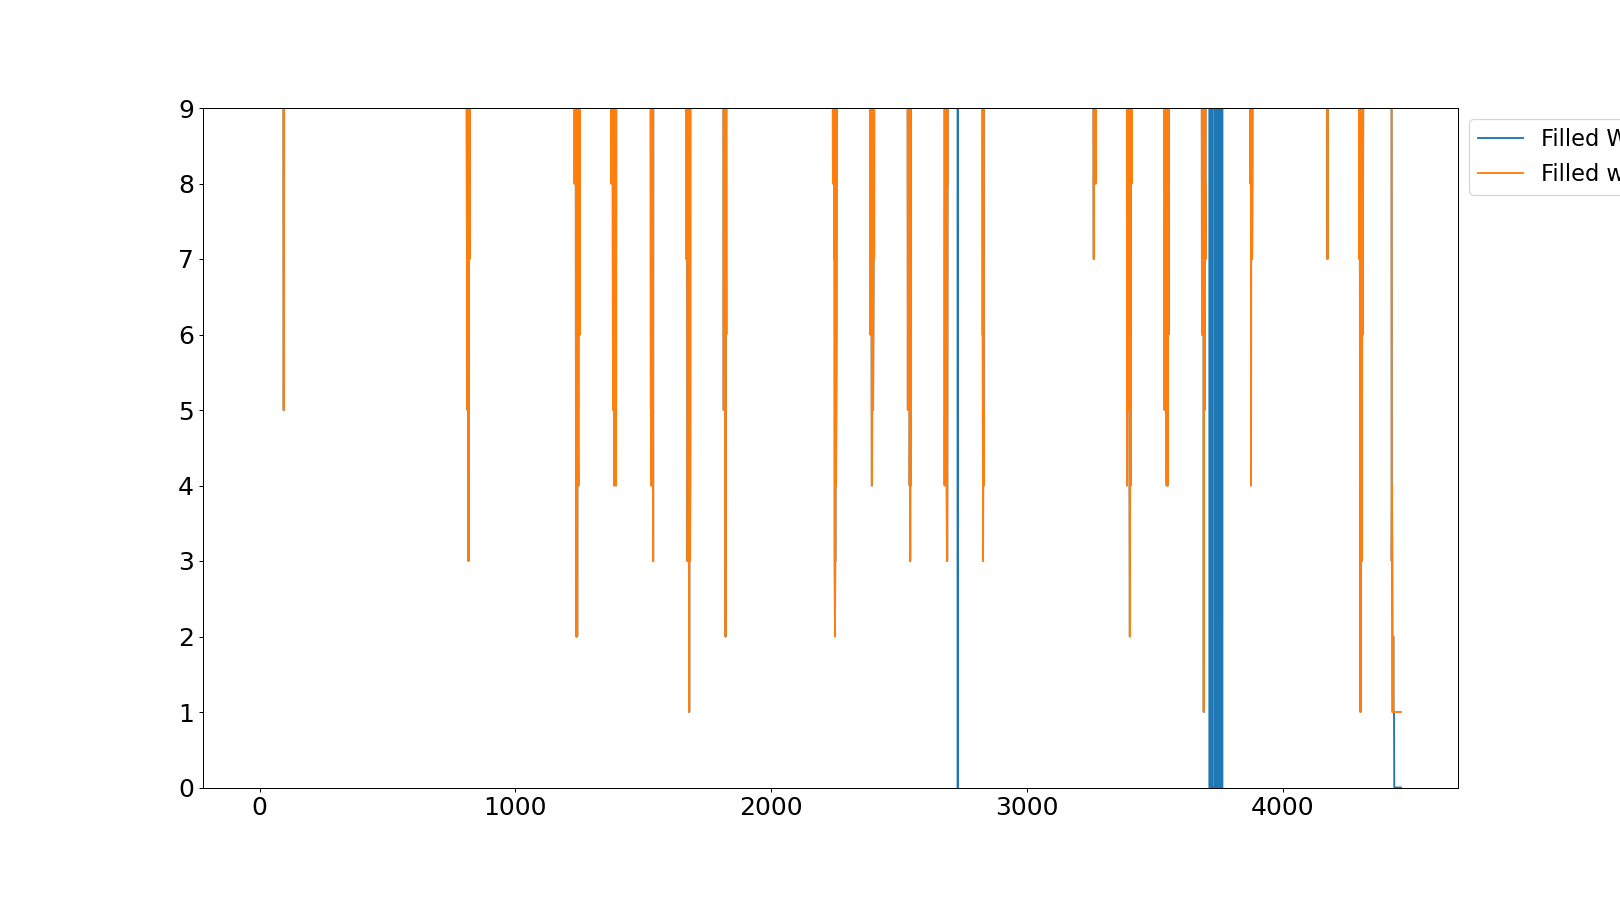

In [121]:
fig = plt.figure(figsize = (18, 10))
plt.plot(jan_2015_fillZero[4464*25:4464*26], label = "Filled With Zero")
plt.plot(jan_2015_fillSmooth[4464*25:4464*26], label = "Filled with Avg Values(Smooth)")
plt.legend(bbox_to_anchor=(1, 1), fontsize = 18)
plt.ylim(0,9)
plt.tick_params(labelsize = 20)
plt.show()

#### Above plot is a plot of all the pickup values for cluster 26th. It shows that all the zero filled are separated by avg filled values. The minimum average filled value is 1.

Ques: Why we choose, these methods and which method is used for which data?

Ans: consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st 
10st 10min interval, 0 pickups happened in 2nd 10mins interval, 0 pickups happened in 3rd 10min interval. 
and 20 pickups happened in 4th 10min interval.
In fillMissingWithZero method we replace these values like 10, 0, 0, 0, 20.
Whereas in "smoothing" method we replace these values as 6,6,6,6,6, if you can check the number of pickups that are happened 
in first 40min are same in both cases, but if you can observe that we looking at the future values. 
When you are using smoothing we are looking at the future number of pickups which might cause a data leakage.

So we use smoothing for jan 2015th data since it acts as our training data
and we use simple fill_misssing method for Jan 2016 data.

In [122]:
unique_binswithPickup_Jan_2016 = getUniqueBinsWithPickups(jan_2016_data)

In [123]:
# Jan-2015 data is smoothed, Jan-2016 data missing values are filled with zero
jan_2016_fillZero = fillMissingWithZero(jan_2016_timeBin_groupBy["trip_distance"].values, unique_binswithPickup_Jan_2016)

In [124]:
regionWisePickup_Jan_2016 = []
for i in range(30):
    regionWisePickup_Jan_2016.append(jan_2016_fillZero[4464*i:((4464*i)+4464)])
#"regionWisePickup_Jan_2016" is a list of lists which contains 30 sub lists, where the index of each sub-list is the 
#corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4464 time bins 
#in Jan 2016, hence, each sub-list is of size 4464.

In [125]:
print(len(regionWisePickup_Jan_2016))
print(len(regionWisePickup_Jan_2016[0]))

30
4464


In [126]:
# def find_missing_timeBins(IDs):
#     missing = []
#     for i in range(len(unique_binswithPickup_Jan_2015[IDs]) - 1):
#         j = unique_binswithPickup_Jan_2015[IDs][i]
#         k = unique_binswithPickup_Jan_2015[IDs][i+1]
#         if (k-j) > 1:
#             for l in range(j+1, k):
#                 missing.append(l)
#     return missing

# 4. Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan-2016 for which we are using multiple models with two variations. 
1. Using Ratios of the 2016 data to the 2015 data i.e $R_{t} = P^{2016}_{t} / P^{2015}_{t}$
2. Using Previous known values of the 2016 data itself to predict the future values

### Preparing dataframe with $x_i$ as Jan- 2015 pickups and $y_i$ as Jan-2016 Pickups, with ratios as $Pickup^{2016} / Pickup^{2015}.$

In [127]:
Ratios_DF = pd.DataFrame()
Ratios_DF["Given"] = jan_2015_fillSmooth
Ratios_DF["Prediction"] = jan_2016_fillZero
Ratios_DF["Ratio"] = Ratios_DF["Prediction"]*1.0/Ratios_DF["Given"]*1.0

In [128]:
Ratios_DF.head()

Given  Prediction     Ratio
0    137          99  0.722628
1    292         199  0.681507
2    252         209  0.829365
3    211         177  0.838863
4    240         198  0.825000

In [129]:
Ratios_DF.shape

(133920, 3)

In [130]:
print("Total Number of zeros in Ratio column = "+str(Ratios_DF["Ratio"].value_counts()[0]))

Total Number of zeros in Ratio column = 4356


In [131]:
print("Total Number of zeros in Prediction column = "+str(Ratios_DF["Prediction"].value_counts()[0]))

Total Number of zeros in Prediction column = 4356


## Simple Moving Average

The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value.<br> 
Using Ratio Values - $R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )$

In [132]:
def simple_moving_average_ratios(ratios):
    predicted_ratio = (ratios["Ratio"].values)[0]
    predicted_ratio_values = []
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 3
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_ratio_values.append(predicted_ratio)
            predicted_pickup_values.append(int(predicted_ratio_values[i] * ratios["Given"].values[i]))
            absolute_error.append(abs(int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]))
            
            error = math.pow((int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            predicted_ratio = sum(ratios["Ratio"].values[(i+1) - window_size:(i+1)])
            predicted_ratio = predicted_ratio/window_size
        else:
            predicted_ratio = sum(ratios["Ratio"].values[0:(i+1)])
            predicted_ratio = predicted_ratio/(i+1)
            
    ratios["Simple_Moving_Average_Ratios_Pred"] = predicted_pickup_values
    ratios["Simple_Moving_Average_Ratios_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

In [133]:
# here, if we calculate absolute percentage error by this formulae: 
# "error = (abs(int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i])) / ratios["Prediction"].values[i]"
#then it will lead to divide by zero problem because many of the values in " ratios["Prediction"].values[i]" are zeros.
# so we used this method to calculate mean absolute percentage error: "mean of error/mean of real values"

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 3 is optimal for getting the best results using Moving Averages using previous Ratio values therefore we get $R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3}) / 3$. We can easily plug any 3 to 5 values which seems to be most effective in reducing MAPE. Like here, we can use 1,2,3,4,5 as the values for window_size and calculate optimal window_size value.

Next we use the Moving averages of the 2016  values itself to predict the future value using $P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n$

In [134]:
def simple_moving_average_predictions(ratios):
    predicted_pickup = (ratios["Prediction"].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 2
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_pickup_values.append(predicted_pickup)
            absolute_error.append(abs(predicted_pickup_values[i] - ratios["Prediction"].values[i]))
            
            error = math.pow((predicted_pickup_values[i] - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            predicted_pickup = sum(ratios["Prediction"].values[(i+1) - window_size:(i+1)])
            predicted_pickup = predicted_pickup/window_size
        else:
            predicted_pickup = sum(ratios["Prediction"].values[0:(i+1)])
            predicted_pickup = predicted_pickup/(i+1)
            
    ratios["Simple_Moving_Average_Predictions_Pred"] = predicted_pickup_values
    ratios["Simple_Moving_Average_Predictions_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Moving Averages using previous 2016 values therefore we get $P_{t} = ( P_{t-1} + P_{t-2} ) / 2$

## Simple Weighted Moving Average
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values: $R_t = (N*R_{t-1} + N-1*R_{t-2} + N-2*R_{T-3} + ...) / N*(N+1)/2$

In [135]:
def weighted_moving_average_ratios(ratios):
    predicted_ratio = (ratios["Ratio"].values)[0]
    predicted_ratio_values = []
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 4
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_ratio_values.append(predicted_ratio)
            predicted_pickup_values.append(int(predicted_ratio_values[i] * ratios["Given"].values[i]))
            absolute_error.append(abs(int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]))
            
            error = math.pow((int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            sumOfRatios = 0
            sumOfWeights = 0
            for j in range(window_size, 0, -1):
                sumOfRatios = sumOfRatios + j*(ratios["Ratio"].values)[i -window_size + j]
                sumOfWeights = sumOfWeights + j
            predicted_ratio = sumOfRatios/sumOfWeights
        else:
            sumOfRatios = 0
            sumOfWeights = 0
            for j in range(i+1, 0, -1):
                sumOfRatios = sumOfRatios + j*(ratios["Ratio"].values)[j-1]
                sumOfWeights = sumOfWeights + j
            predicted_ratio = sumOfRatios/sumOfWeights
    
    ratios["Weighted_Moving_Average_Ratios_Pred"] = predicted_pickup_values
    ratios["Weighted_Moving_Average_Ratios_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 4 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $ R_{t} = ( 4*R_{t-1} + 3*R_{t-2} + 2*R_{t-3} + 1*R_{t-4})/10$

Weighted Moving Averages using Previous 2016 Values - $P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2)$

In [136]:
def weighted_moving_average_predictions(ratios):
    predicted_pickup = (ratios["Prediction"].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    window_size = 2
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_pickup_values.append(predicted_pickup)
            absolute_error.append(abs(predicted_pickup_values[i] - ratios["Prediction"].values[i]))
            
            error = math.pow(int(predicted_pickup_values[i] - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            
        if (i+1)>=window_size:
            sumPickups = 0
            sumOfWeights = 0
            for j in range(window_size, 0, -1):
                sumPickups = sumPickups + j*(ratios["Prediction"].values)[i -window_size + j]
                sumOfWeights = sumOfWeights + j
            predicted_pickup = sumPickups/sumOfWeights
        else:
            sumPickups = 0
            sumOfWeights = 0
            for j in range(i+1, 0, -1):
                sumPickups += j*(ratios["Prediction"].values)[j-1]
                sumOfWeights += j
            predicted_pickup = sumPickups/sumOfWeights
    
    ratios["Weighted_Moving_Average_Predictions_Pred"] = predicted_pickup_values
    ratios["Weighted_Moving_Average_Predictions_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

For the above the Hyperparameter is the window-size (n) which is tuned manually and it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages using previous Ratio values therefore we get $ P_t = ( 2*P_{t-1} + 1*P_{t-2})/2$

## Exponential Weighted Moving Average

Here we will use previous predicted result along with previous actual value to make predictions for next value.
$R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}$

$R^′_t$ is the current predicted ratio.<br>
$R^′_{t-1}$ is the previous predicted ratio.<br>
$R_{t-1}$ is the actual previous ratio.<br>
Let say alpha = 0.7.<br>
Now, when alpha = 0.7, then it means we are giving 70% weightage to the previous predicted ratio and 30% weightage to the previous actual ratio.<br>
$R^′_0$ = 0<br>
$R^′_1 = 0.7*R^′_0 + 0.3*R_0$<br>
$R^′_2 = 0.7*R^′_1 + 0.3*R_1$<br>
$R^′_3 = 0.7*R^′_2 + 0.3*R_2$<br>
Let’s take $R^′_3$.<br>
$R^′_3  = 0.3* R_2 + 0.7* R^′_2$<br>
$R^′_3  = 0.3* R_2 + 0.7*(0.3* R_1 + 0.7*R^′_1)$<br>
$R^′_3  = 0.3* R_2 + 0.7 * ( 0.3* R_1 + 0.7* ( 0.3* R_0 + 0.7* R^′_0 ) )$<br>
$R^′_3  = 0.3* R_3 + 0.7*0.3* R_1 + 0.7*0.7*0.3* R_0 + 0.7*0.7*0.7* R^′_0$<br>
$R^′_3  = 0.3* R_3 + 0.7*0.3* R_1 + 0.7*0.7*0.3* R_0 + 0$<br>

In [137]:
def exponential_weighted_moving_average_ratios(ratios):
    predicted_ratio = (ratios["Ratio"].values)[0]
    predicted_ratio_values = []
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    alpha = 0.5
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_ratio_values.append(predicted_ratio)
            predicted_pickup_values.append(int(predicted_ratio_values[i] * ratios["Given"].values[i]))
            absolute_error.append(abs(int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]))
            error = math.pow((int(predicted_ratio_values[i] * ratios["Given"].values[i]) - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            predicted_ratio = alpha*predicted_ratio + ((1-alpha)*ratios["Ratio"].values[i-1])
            
            
    ratios["Exponential_Weighted_Moving_Average_Ratios_Pred"] = predicted_pickup_values
    ratios["Exponential_Weighted_Moving_Average_Ratios_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

Here, above, alpha is a hyper-parameter which needs to be tuned manually. It is found that alpha = 0.5 gives lowest MAPE value.

$P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}$

In [138]:
def exponential_weighted_moving_average_predictions(ratios):
    predicted_pickup = (ratios["Prediction"].values)[0]
    predicted_pickup_values = []
    absolute_error = []
    squared_error = []
    alpha = 0.5
    for i in range(4464*30):
        if i % 4464 == 0:
            predicted_pickup_values.append(0)
            absolute_error.append(0)
            squared_error.append(0)
        else:
            predicted_pickup_values.append(predicted_pickup)
            absolute_error.append(abs(predicted_pickup_values[i] - ratios["Prediction"].values[i]))
            error = math.pow((predicted_pickup_values[i] - ratios["Prediction"].values[i]), 2)
            squared_error.append(error)
            predicted_pickup = alpha*predicted_pickup + ((1-alpha)*ratios["Prediction"].values[i-1])
            
            
    ratios["Exponential_Weighted_Moving_Average_Predictions_Pred"] = predicted_pickup_values
    ratios["Exponential_Weighted_Moving_Average_Predictions_AbsError"] = absolute_error
    mean_absolute_percentage_error = (sum(absolute_error)/len(absolute_error)) / (sum(ratios["Prediction"]) / len(ratios["Prediction"]))
    mean_sq_error = sum(squared_error)/len(squared_error)
    return ratios, mean_absolute_percentage_error, mean_sq_error

In [139]:
r1, mape1, mse1 = simple_moving_average_ratios(Ratios_DF)
r2, mape2, mse2 = simple_moving_average_predictions(Ratios_DF)
r3, mape3, mse3 = weighted_moving_average_ratios(Ratios_DF)
r4, mape4, mse4 = weighted_moving_average_predictions(Ratios_DF)
r5, mape5, mse5 = exponential_weighted_moving_average_ratios(Ratios_DF)
r6, mape6, mse6 = exponential_weighted_moving_average_predictions(Ratios_DF)

In [140]:
error_table_baseline = pd.DataFrame(columns = ["Model", "MAPE(%)", "MSE"])

error_table_baseline = error_table_baseline.append(pd.DataFrame([["Simple Moving Average Ratios", mape1*100, mse1]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Simple Moving Average Predictions", mape2*100, mse2]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Weighted Moving Average Ratios", mape3*100, mse3]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Weighted Moving Average Predictions", mape4*100, mse4]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Exponential Weighted Moving Average Ratios", mape5*100, mse5]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Exponential Weighted Moving Average Predictions", mape6*100, mse6]], columns = ["Model", "MAPE(%)", "MSE"]))

error_table_baseline.reset_index(drop = True, inplace = True)

In [141]:
error_table_baseline.style.highlight_min(axis=0)

<b>Plese Note:-</b> The above comparisons are made using Jan 2015 and Jan 2016 only

<b>From the above error table it is inferred that the best forecasting model for our prediction would be:-</b>
$P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2)$ i.e Weighted Moving Averages Predictions using 2016 Values.

# 5. Regression Models

### Preparing Data

Preparing data to be split into train and test, The below code prepares data in cumulative form which will be later split into
test and train

There are total 30 clusters and for the month of January-2016 and there are total 4464 time bins. 
For each cluster region there are 4464 time bins and so, for 30 clusters there will be 4464*30 pickup values because after 
smoothing each time bin has pickup.
We will have a total of 4464*30 = 133920 pickup values.

In [142]:
#"regionWisePickup_Jan_2016" is a list of lists which contains 30 sub lists, where the index of each sub-list is the 
#corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4464 time bins 
#in Jan 2016, hence, each sub-list is of size 4464.
#"regionWisePickup_Jan_2016" is a list of lists [[x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], .. 30 lists]
#Here, x1,x2,x3... are pickup values at time stamp 1,2,3... respectively

# print(len(regionWisePickup_Jan_2016))
# 30
# print(len(regionWisePickup_Jan_2016[0]))
# 4464

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# TruePickups varaible
# it is list of lists
# It will be used as true labels/ground truth. Now since we are taking previous 5 pickups as a training data for predicting
# next pickup(here next pickup will be a true/ground truth pickup), so "TruePickups" will not contain first five pickups of each 
# cluster. It will contain number of pickups 4459 for each cluster. 
TruePickups = []


# lat will contain 4464-5=4459 times latitude of cluster center for every cluster.
# Ex: [[cent_lat 4459 times],[cent_lat 4459 times], [cent_lat 4459 times].... 30 lists]
# it is list of lists
lat = []


# lon will contain 4464-5=4459 times longitude of cluster center for every cluster.
# Ex: [[cent_lat 4459 times],[cent_lat 4459 times], [cent_lat 4459 times].... 30 lists]
# it is list of lists
lon = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
day_of_week = []


# for every cluster we will be adding 4459 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists

# feat is a numbpy array, of shape (133770, 5). {4459*30 = 133770.}
# each row corresponds to an entry in our data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1st 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
feat = []


centerOfRegions = regions.cluster_centers_
feat = [0]*number_of_time_stamps
for i in range(30):
    lat.append([centerOfRegions[i][0]]*4459) 
    lon.append([centerOfRegions[i][1]]*4459)
    #1 January 2016 is a Friday so we start our day from 5: "(int(j/144))%7+5"
    # Our prediction starts from 5th 10min interval since we need to have number of pickups that are happened in last 5 pickup bins.
    day_of_week.append([int(((int(j/144)%7)+5)%7) for j in range(5, 4464)])
    #"regionWisePickup_Jan_2016" is a list of lists which contains 30 sub lists, where the index of each sub-list is the 
    #corresponding cluster number and the element of each sub-list is the pickup value. So, we know that there are 4464 time bins 
    #in Jan 2016, hence, each sub-list is of size 4464.
    #"regionWisePickup_Jan_2016" is a list of lists [[x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], [x1,x2,x3..4464], .. 30 lists]
    #Here, x1,x2,x3... are pickup values at time stamp 1,2,3... respectively
    feat = np.vstack((feat, [regionWisePickup_Jan_2016[i][k:k+number_of_time_stamps] for k in range(0, len(regionWisePickup_Jan_2016[i]) - (number_of_time_stamps))]))
    TruePickups.append(regionWisePickup_Jan_2016[i][5:])
    #output contains pickup values of all the regions and of each time stamp, except first 5 time stamp pickups of each region.
feat = feat[1:]

In [143]:
len(lat[0])*len(lat) == len(lon[0])*len(lon) == len(day_of_week[0])*len(day_of_week) == 4459*30 == len(feat) == len(TruePickups[0])*len(TruePickups)

True

In [144]:
feat

array([[ 99, 199, 209, 177, 198],
       [199, 209, 177, 198, 211],
       [209, 177, 198, 211, 205],
       ...,
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]], dtype=int64)

### Adding Predictions of Weighted Moving Average Predictions as a feature in our data

Getting the predictions of weighted moving averages to be used as a feature in cumulative form.

Upto now we computed 8 features for every data point that starts from 50th min of the day.
1. cluster center latitude
2. cluster center longitude
3. day of the week 
4. f_t_1: number of pickups that are happened previous t-1st 10min interval
5. f_t_2: number of pickups that are happened previous t-2nd 10min interval
6. f_t_3: number of pickups that are happened previous t-3rd 10min interval
7. f_t_4: number of pickups that are happened previous t-4th 10min interval
8. f_t_5: number of pickups that are happened previous t-5th 10min interval

From the baseline models we said that the weighted moving avarage predictions gives us the best error.
We will try to add the same weighted moving avarage predictions at time t as a feature to our data.<br>
Weighted Moving Average -> $P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2)$

In [145]:
# "predicted_pickup_values": it is a temporary array that store weighted moving avarag prediction values for each 10min intervl, 
# for each cluster it will get reset.
# for every cluster it contains 4464 values
predicted_pickup_values = []

# "predicted_pickup_values_list"
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x4463], [x5,x6,x7..x4463], [x5,x6,x7..x4463], ... 40 lists]
predicted_pickup_values_list = []

predicted_value = -1  #it will contain cuurent predicted_value. Default is given -1 which will be replaced later

window_size = 2
for i in range(30):
    for j in range(4464):
        if j == 0:
            predicted_value = regionWisePickup_Jan_2016[i][j]
            predicted_pickup_values.append(0)
        else:
            if j>=window_size:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(window_size, 0, -1):
                    sumPickups += k*(regionWisePickup_Jan_2016[i][j -window_size + (k - 1)])
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
            else:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(j, 0, -1):
                    sumPickups += k*regionWisePickup_Jan_2016[i][k-1]
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
                
    predicted_pickup_values_list.append(predicted_pickup_values[5:])
    predicted_pickup_values = []

In [146]:
len(predicted_pickup_values_list[0])*len(predicted_pickup_values_list) == 4459*30

True

### Adding Top 5 Frequencies and Amplitudes of Fourier Transform as features

Fourier Transform says that whenever we have a repeating pattern in a wave like here we have a repeating pattern of pickups in 24hrs of time period, this repeating wave can be decomposed into sum of multiple sine waves. Each sine wave will have some frequency and amplitude. Now we can represent our original wave from time-domain to frequency-domain, where frequency will be presented on x-axis and amplitude will presented on y-axis. In frequency domain the x-axis frequencies will be discrete frequencies of individual sine waves and y-axis amplitudes will be their corresponding amplitude values.<br><br>

In time-series data whenever we have a repeating pattern then the Fourier decomposed frequencies and their amplitude can be added as a features in our data. As these features are very useful particularly when we have a repeating pattern in a time-series data.<br><br>

Intuitively, amplitude measures how significant one frequency is as compared to other frequency in a relative sense. More the amplitude, more of the time-series that sine-wave can represent. So, we can simply find the frequencies with maximal amplitudes by simple sorting them to obtain the important frequencies and their corresponding amplitudes. Finally we can add them as a feature in our data.<br><br>

Now we have a total of 30 clusters in our data. In each individual cluster the pickup pattern(which is repeating) will remain same. Note that pickup pattern in different clusters will be different. So, when we plot FFT for one cluster, and let say that one cluster contains ‘n’ points, and if we take first 3 frequencies and their corresponding amplitude values as a feature, then for all of those ‘n’ points, these 3 frequencies and their corresponding amplitudes will remain same. It will change only for the points which are in another cluster.<br><br>

<IPython.core.display.Javascript object>


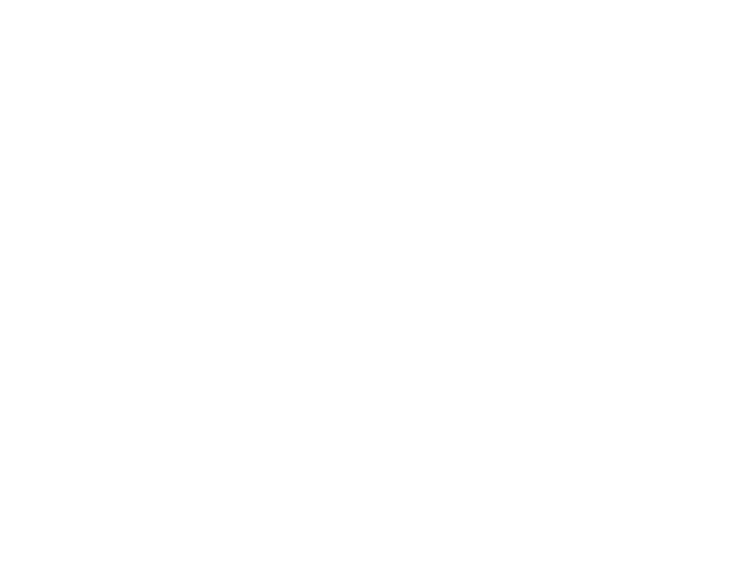

<IPython.core.display.Javascript object>


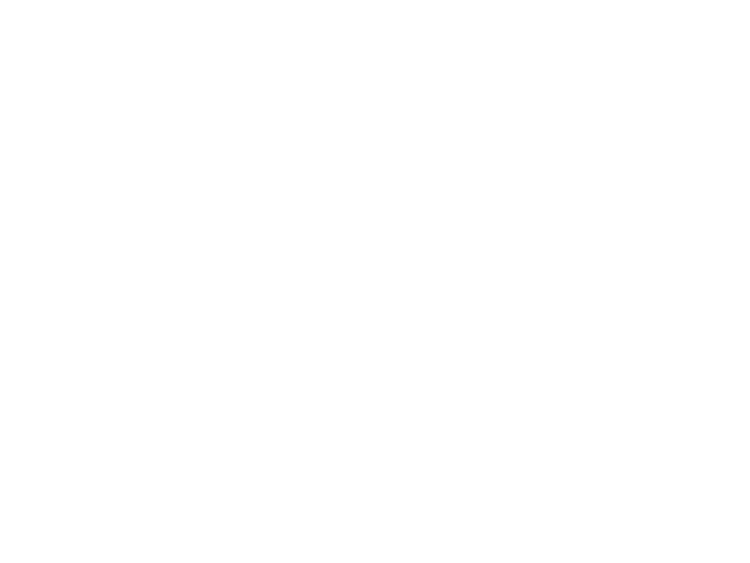

<IPython.core.display.Javascript object>


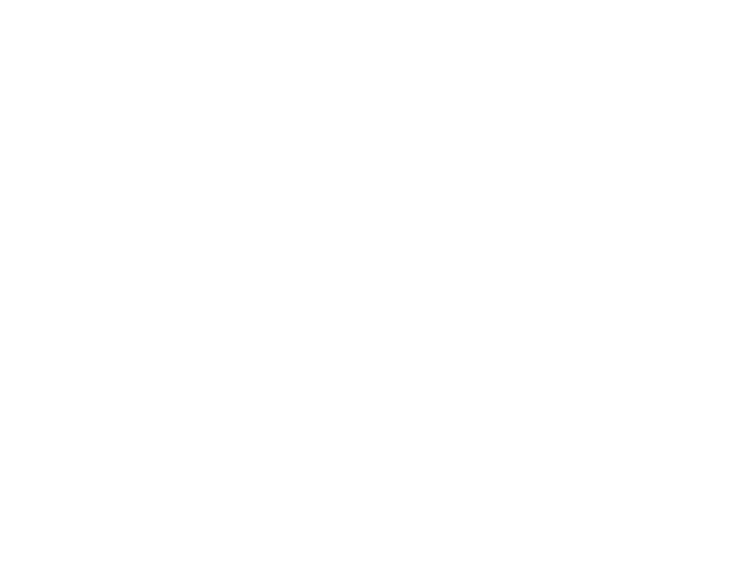

<IPython.core.display.Javascript object>


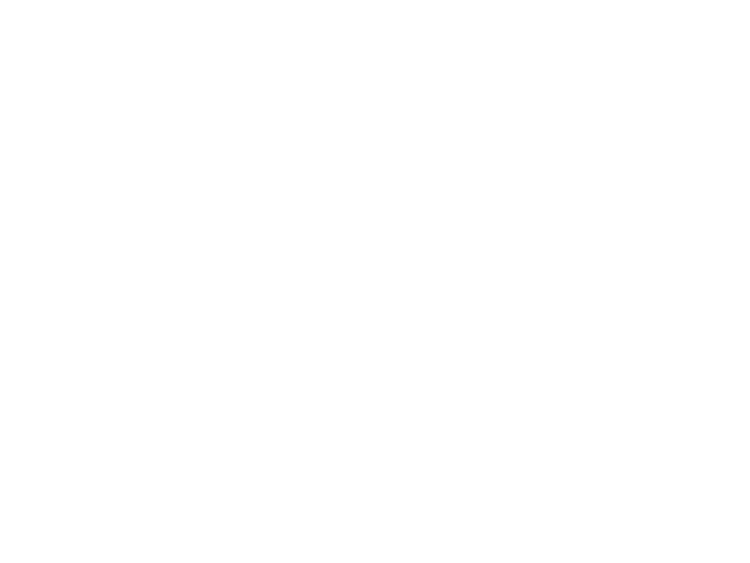

<IPython.core.display.Javascript object>


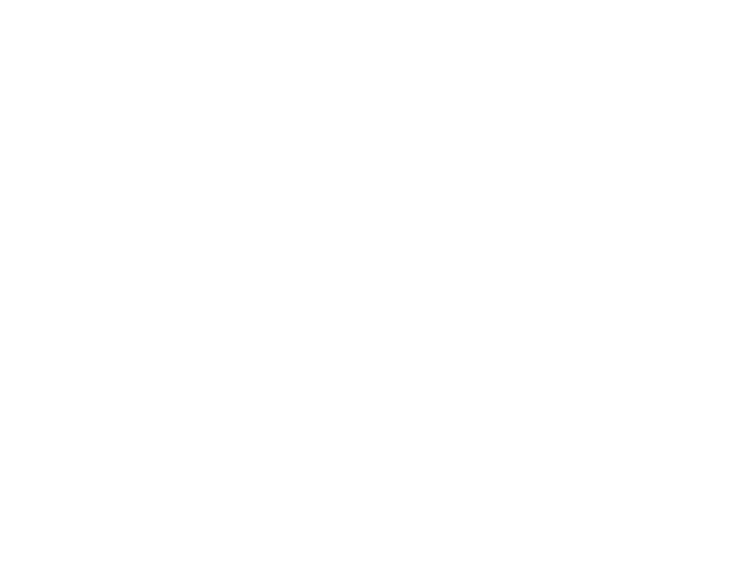

<IPython.core.display.Javascript object>


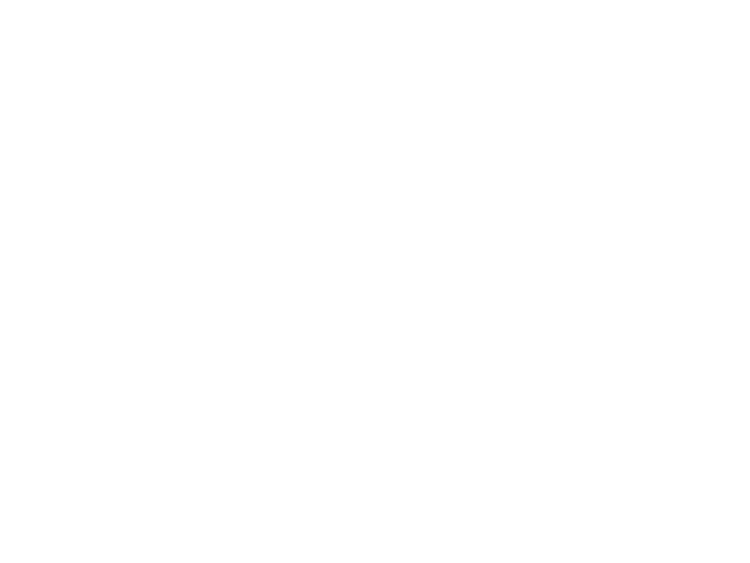

<IPython.core.display.Javascript object>


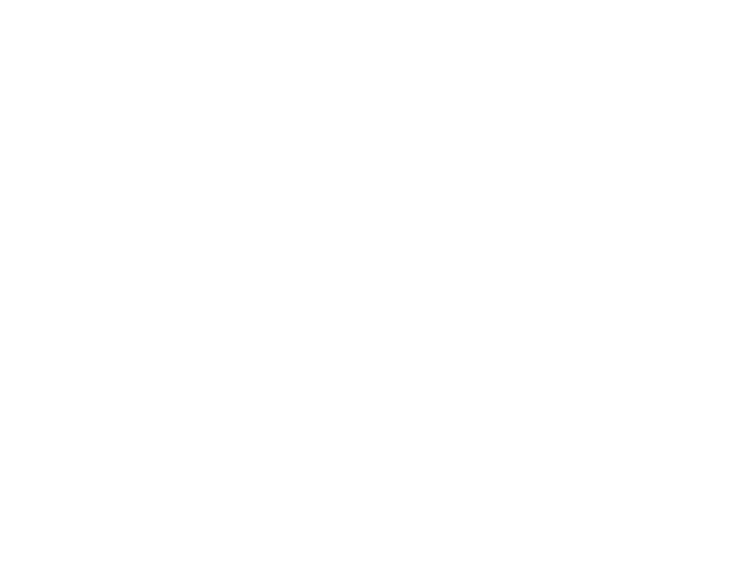

<IPython.core.display.Javascript object>


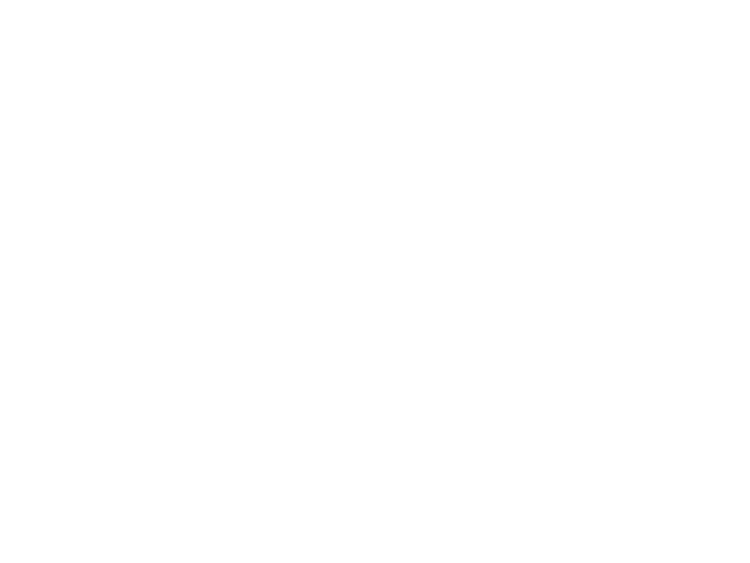

<IPython.core.display.Javascript object>


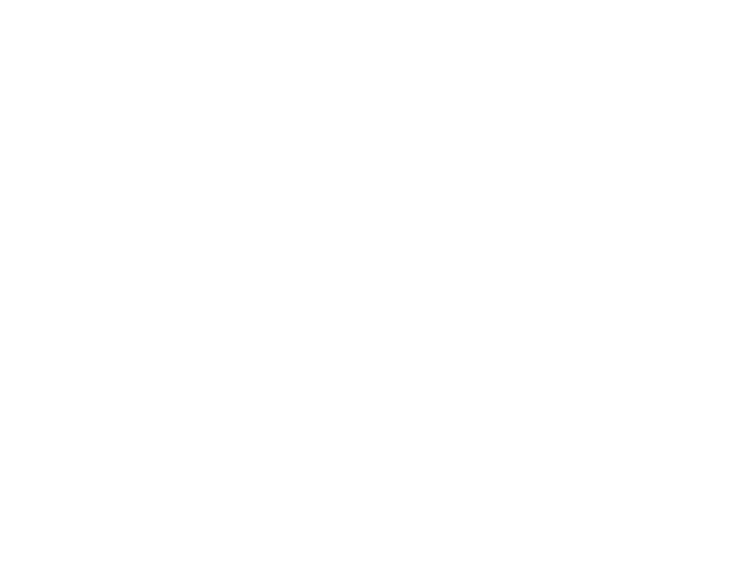

<IPython.core.display.Javascript object>


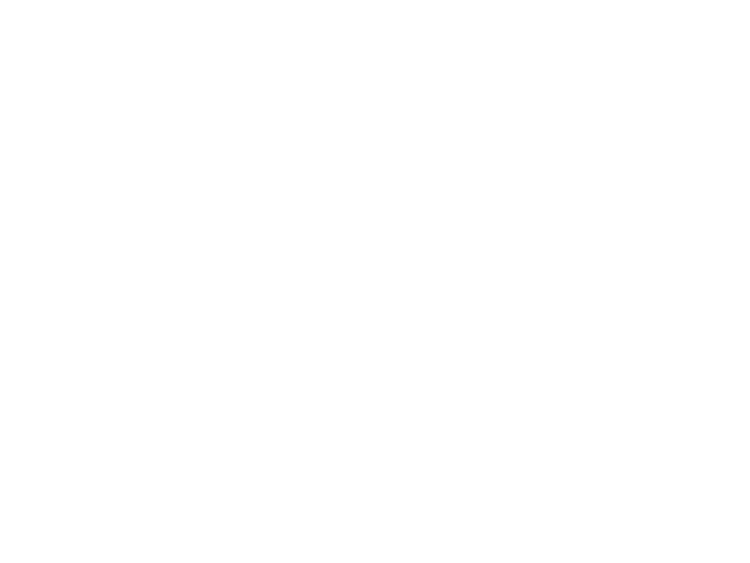

<IPython.core.display.Javascript object>


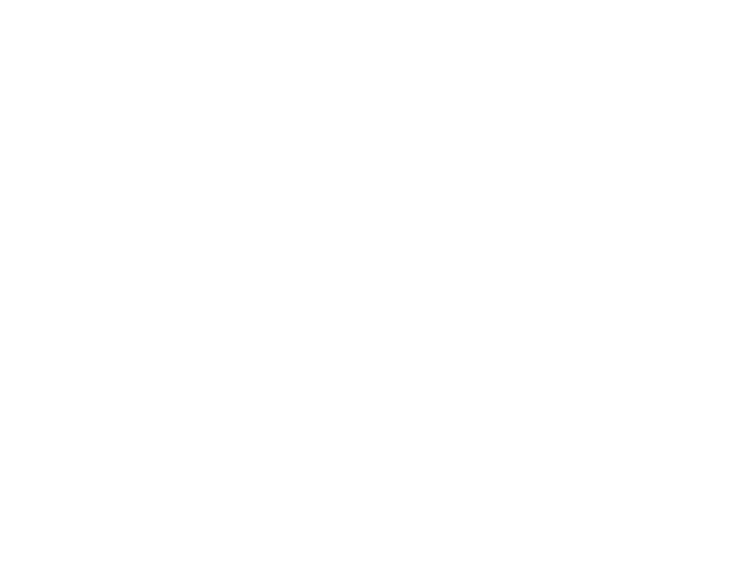

<IPython.core.display.Javascript object>


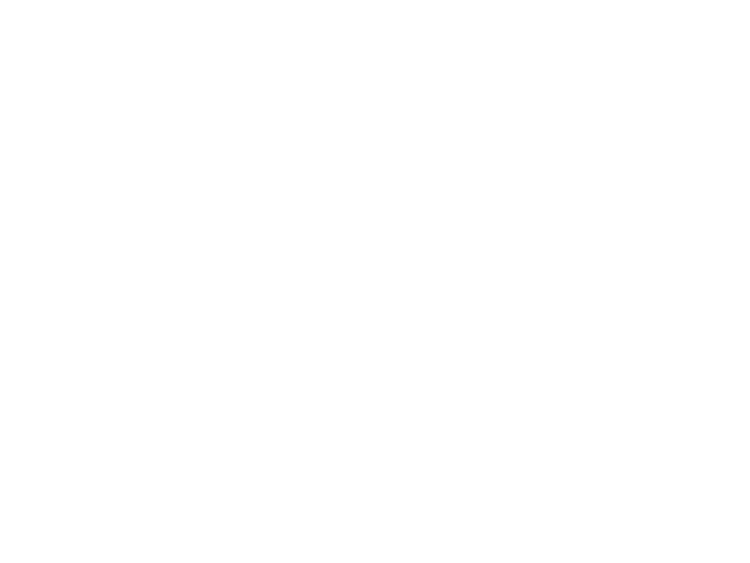

<IPython.core.display.Javascript object>


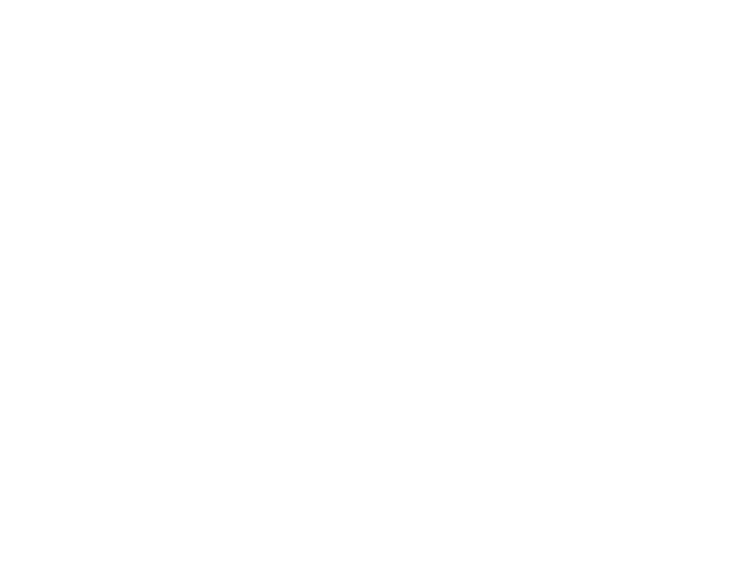

<IPython.core.display.Javascript object>


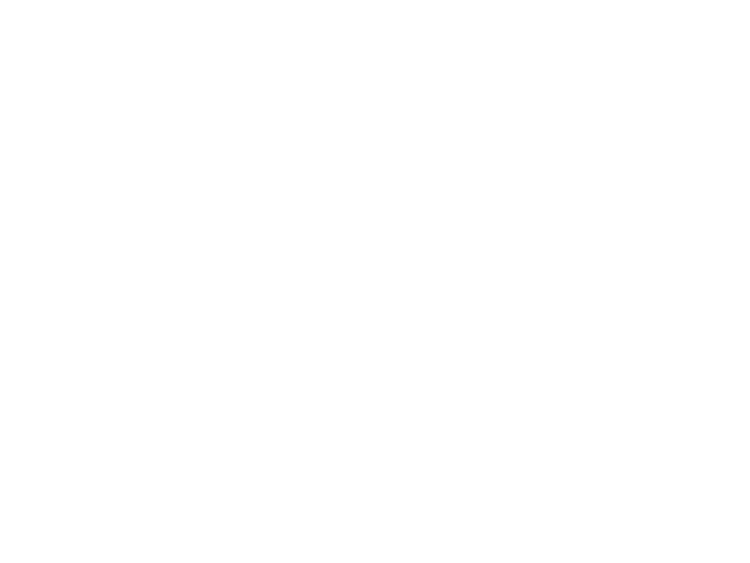

<IPython.core.display.Javascript object>


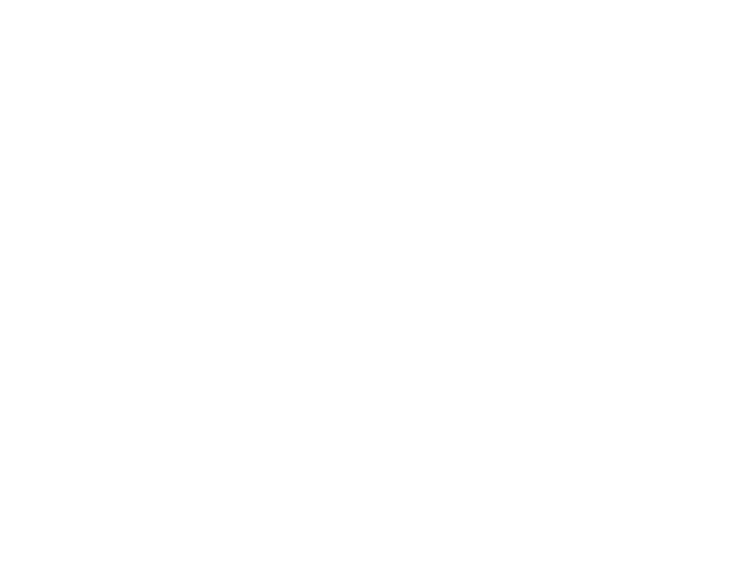

<IPython.core.display.Javascript object>


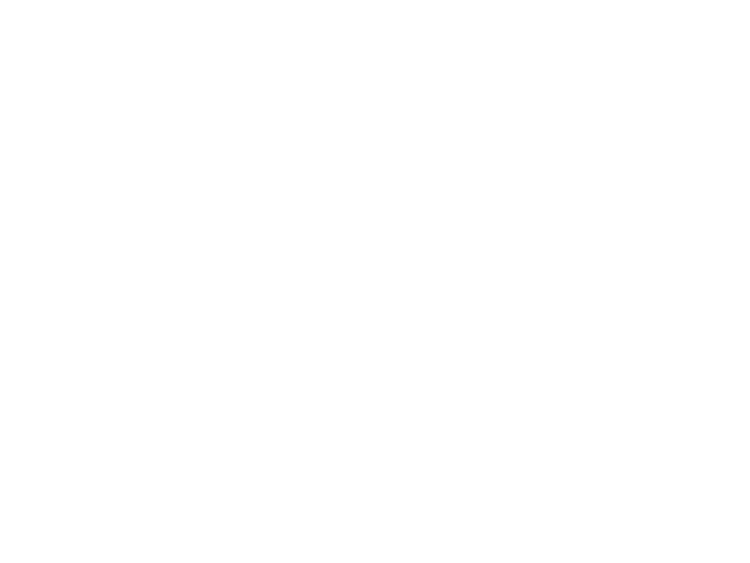

<IPython.core.display.Javascript object>


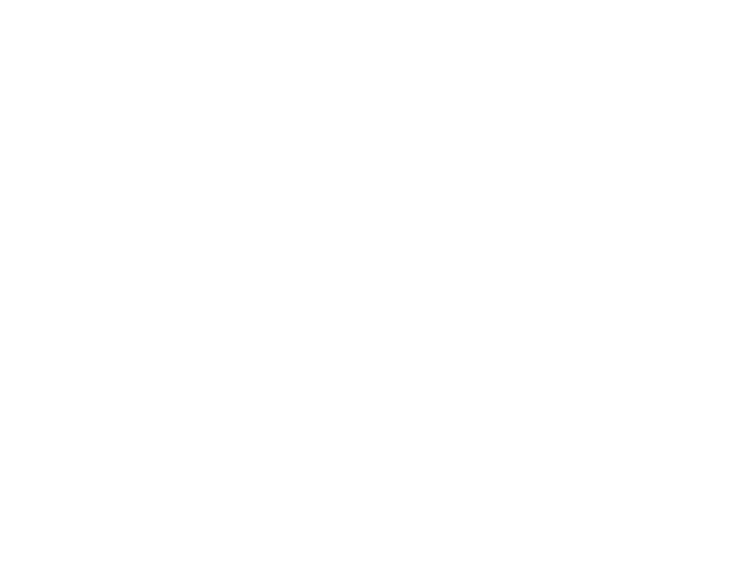

<IPython.core.display.Javascript object>


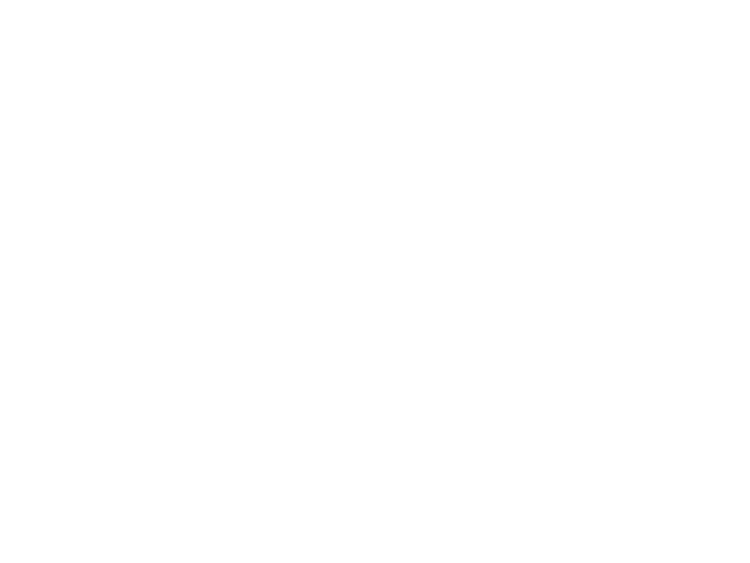

<IPython.core.display.Javascript object>


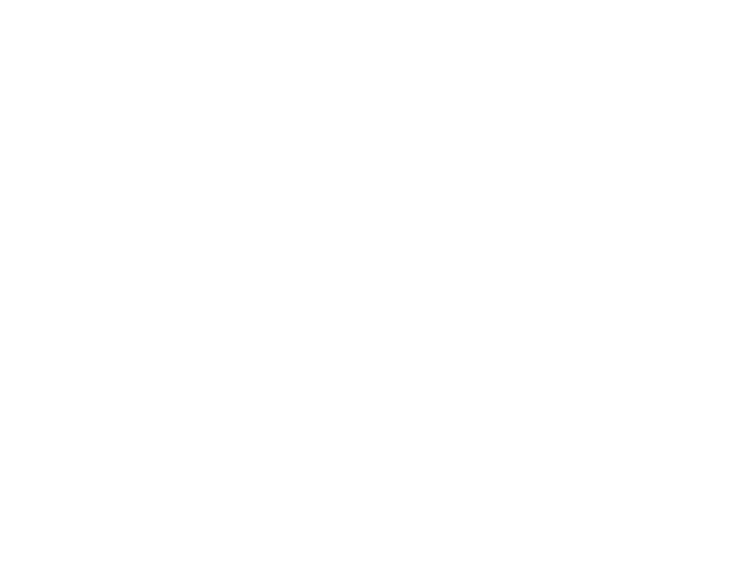

<IPython.core.display.Javascript object>


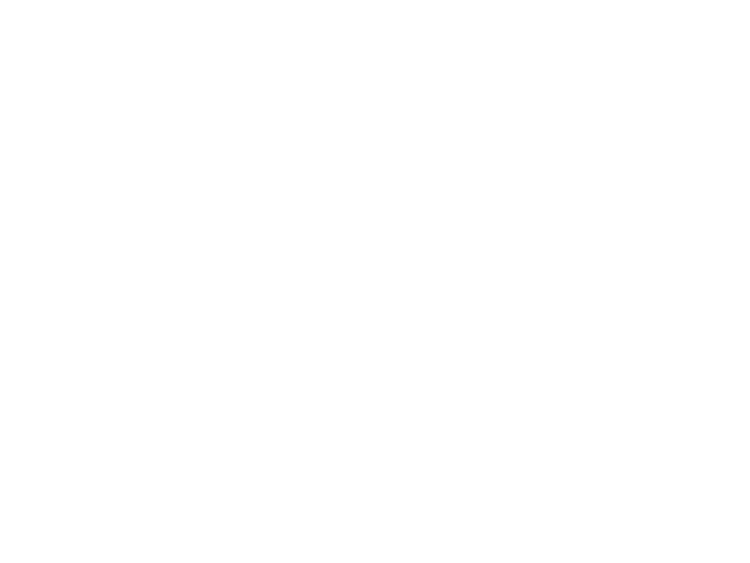

<IPython.core.display.Javascript object>


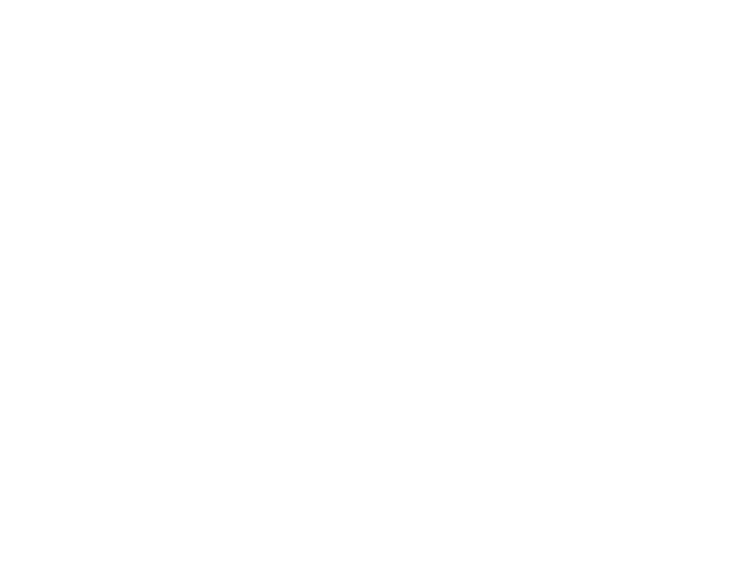

<IPython.core.display.Javascript object>


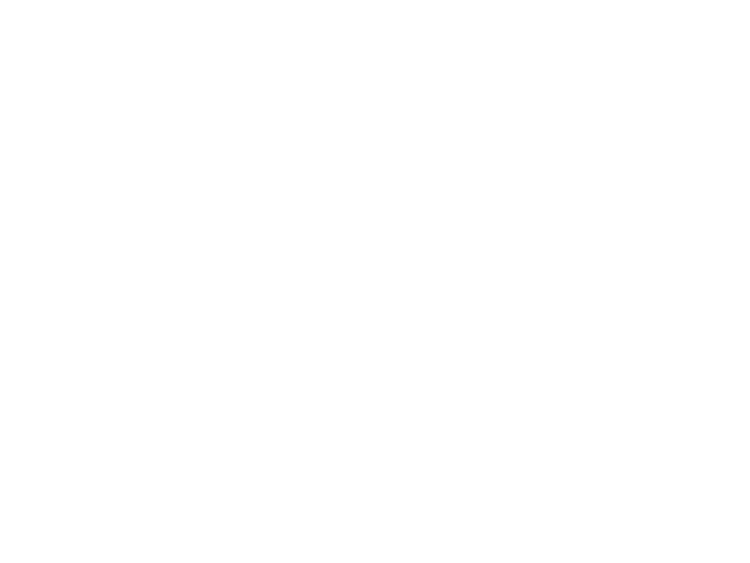

<IPython.core.display.Javascript object>


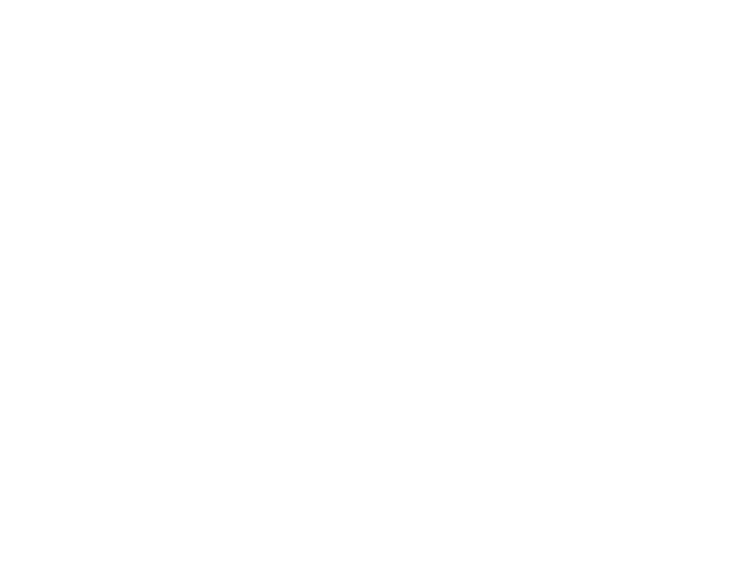

<IPython.core.display.Javascript object>


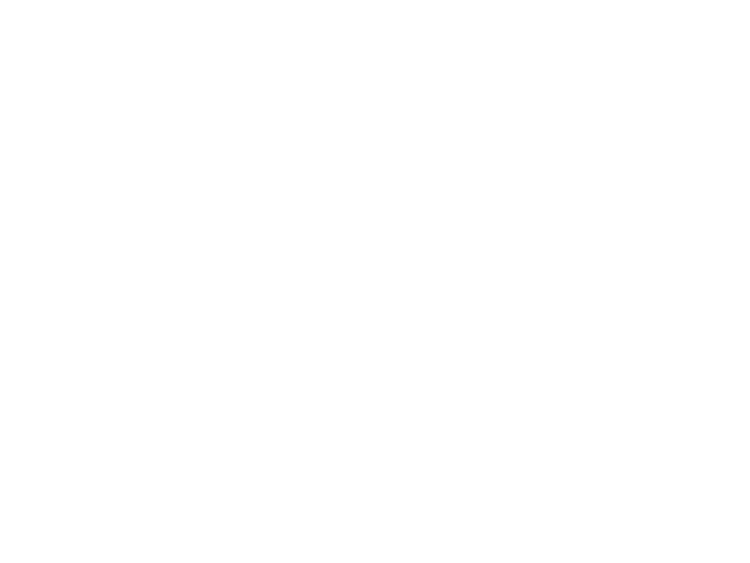

<IPython.core.display.Javascript object>


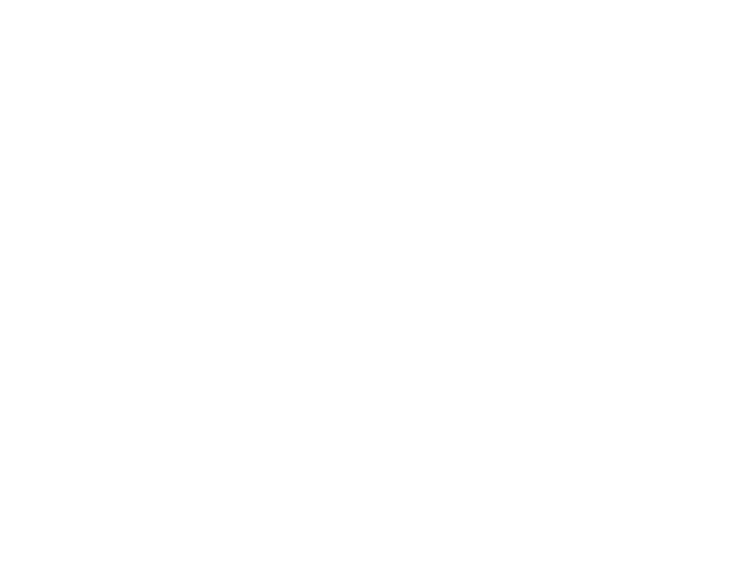

<IPython.core.display.Javascript object>


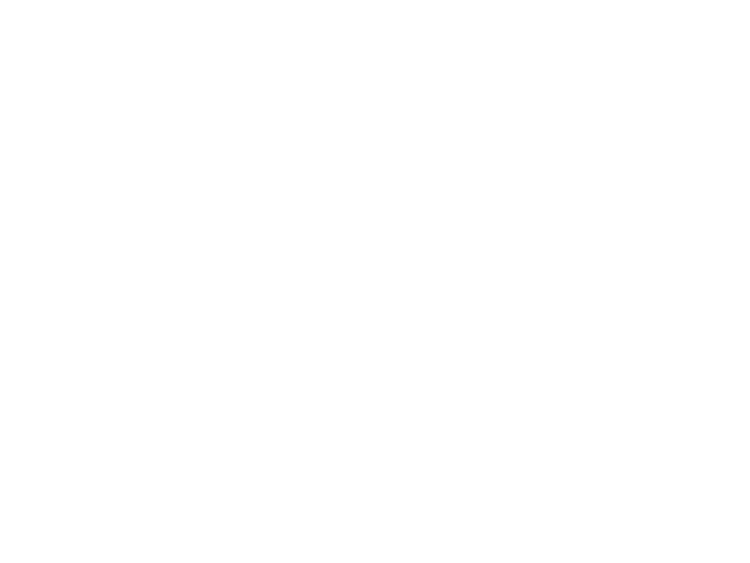

<IPython.core.display.Javascript object>


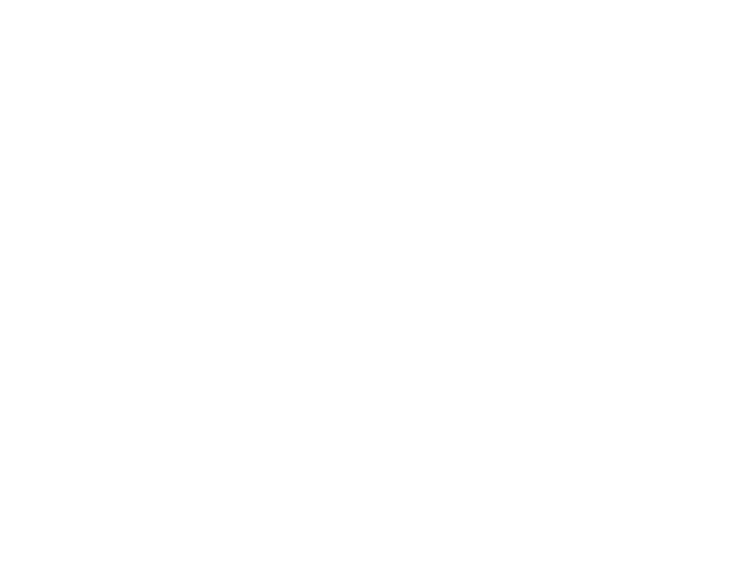

<IPython.core.display.Javascript object>


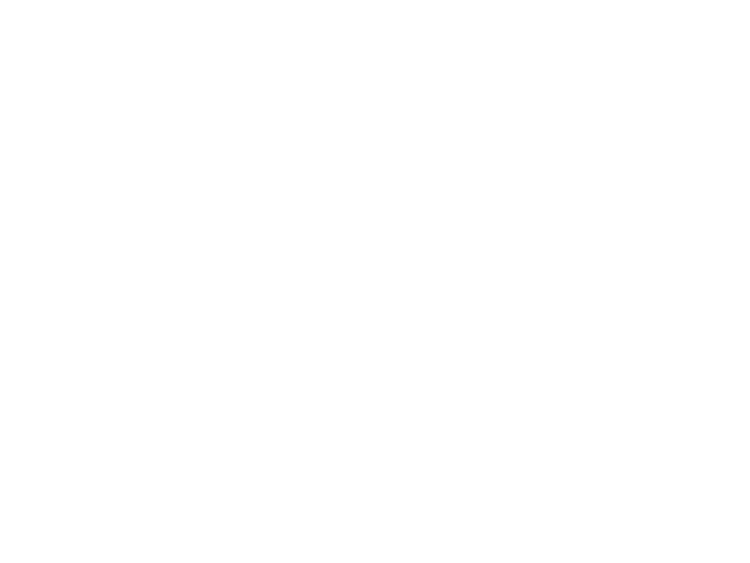

<IPython.core.display.Javascript object>


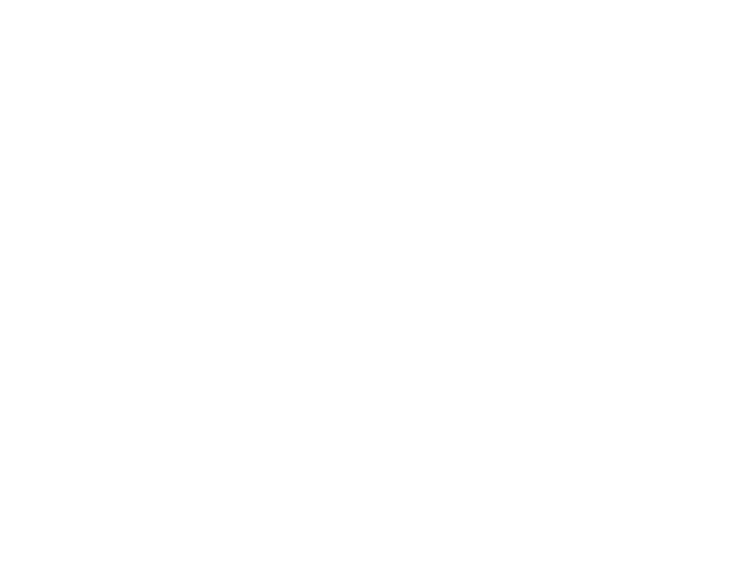

<IPython.core.display.Javascript object>


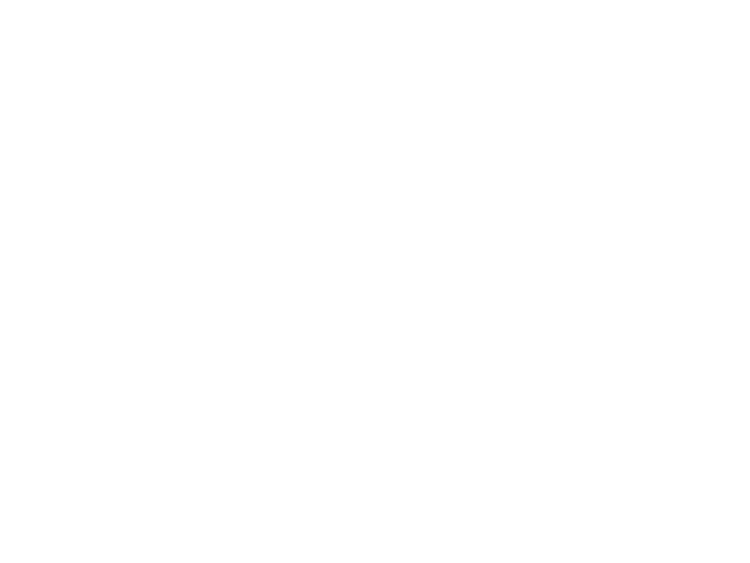

In [147]:
%matplotlib notebook
for i in range(30):
    fig = plt.figure(figsize = (8, 6))
    plt.plot(regionWisePickup_Jan_2016[i][:4464])
    plt.title("Pickup Pattern for Cluster Region "+str(i+1)+", for Jan-2016.")
    plt.xlabel("10 Minute Time Bins")
    plt.ylabel("Number of Pickups")

<b>From the above graphs of pickups of each cluster we can observe that there is a repeating pattern in pickups in 24hrs time period. Now we can decompose these repeating waves by using fourier transform and use their frequencies and their corresponding amplitudes as features in our data.</b>

<IPython.core.display.Javascript object>


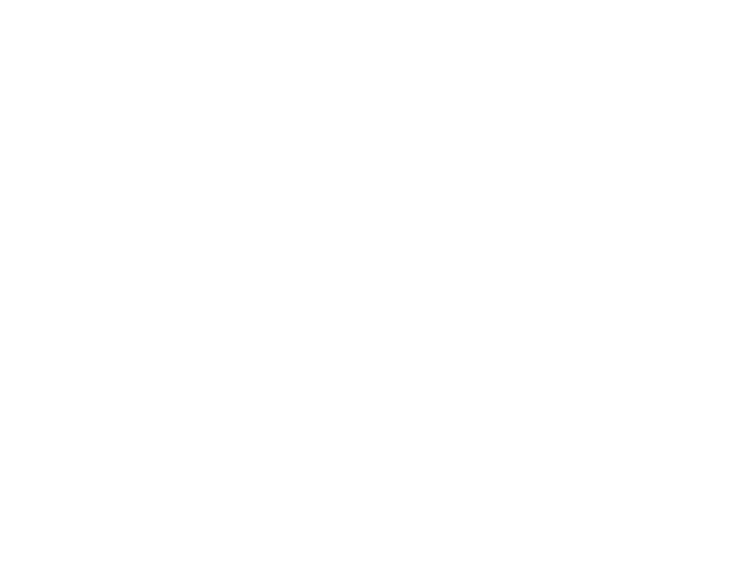

<IPython.core.display.Javascript object>


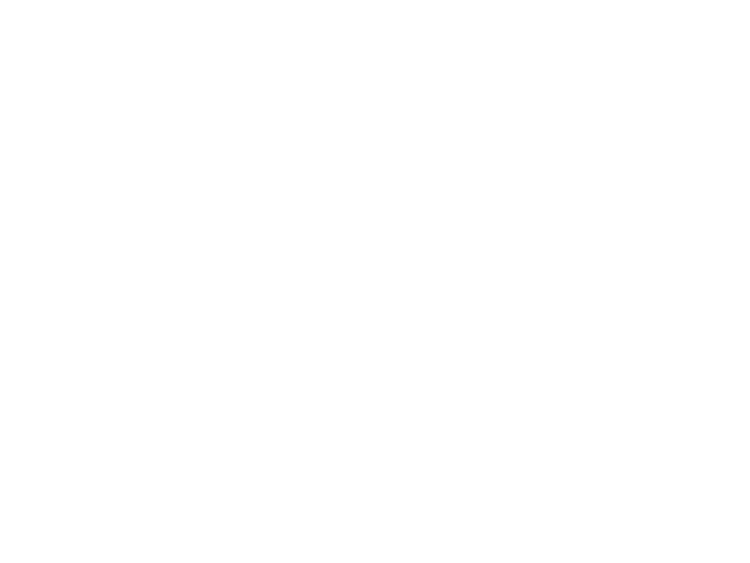

<IPython.core.display.Javascript object>


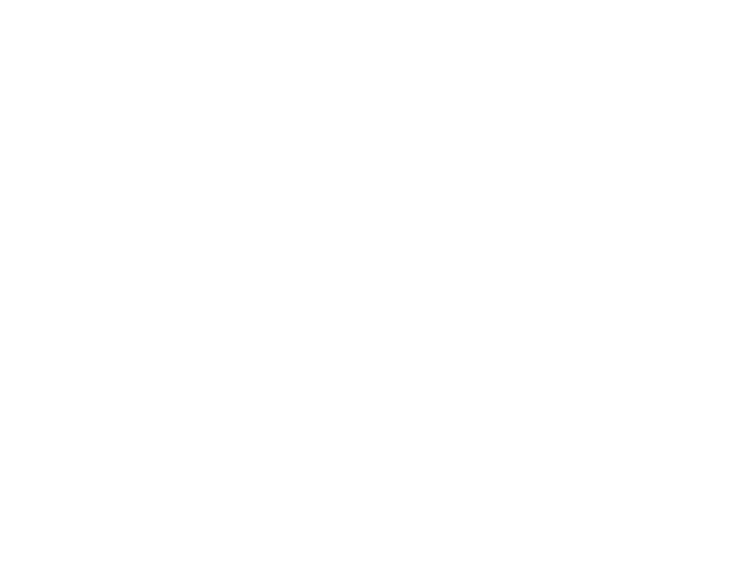

<IPython.core.display.Javascript object>


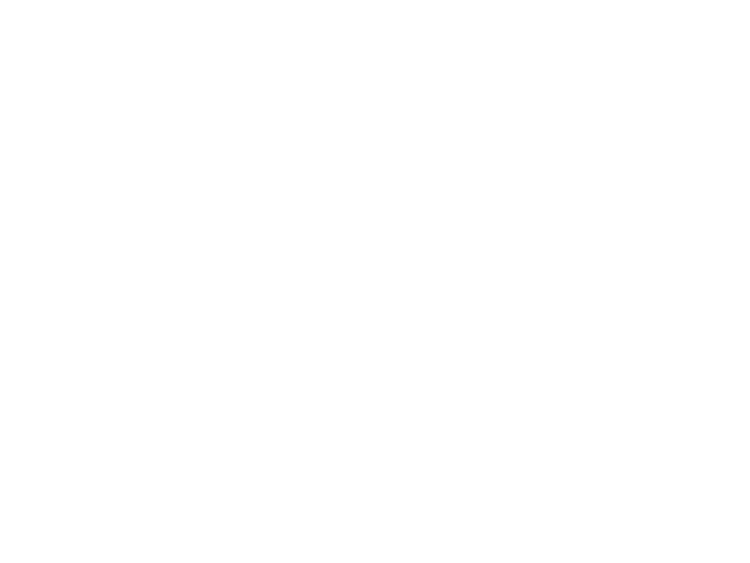

<IPython.core.display.Javascript object>


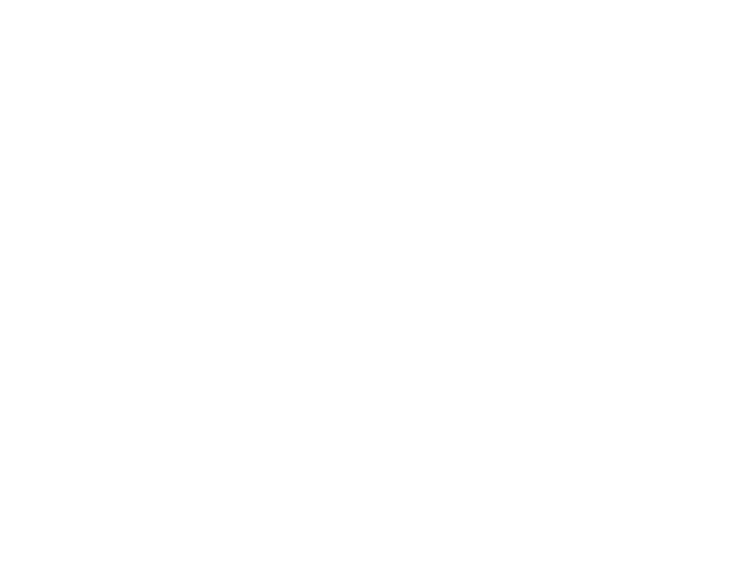

<IPython.core.display.Javascript object>


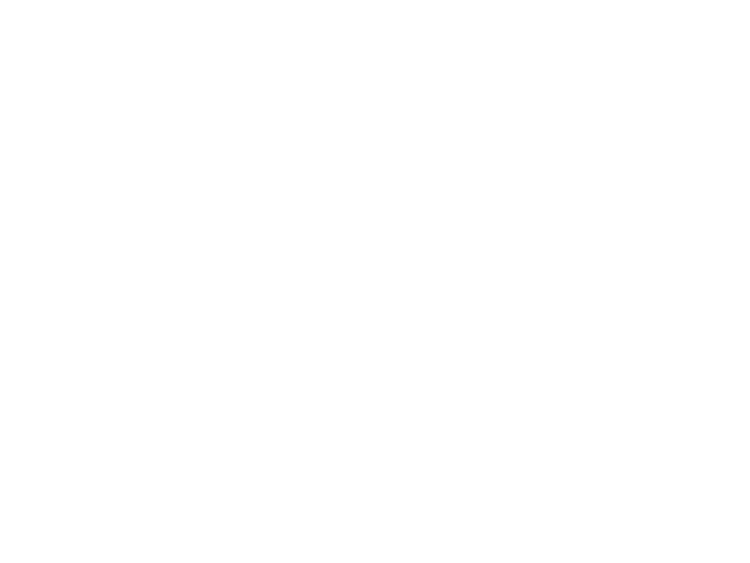

<IPython.core.display.Javascript object>


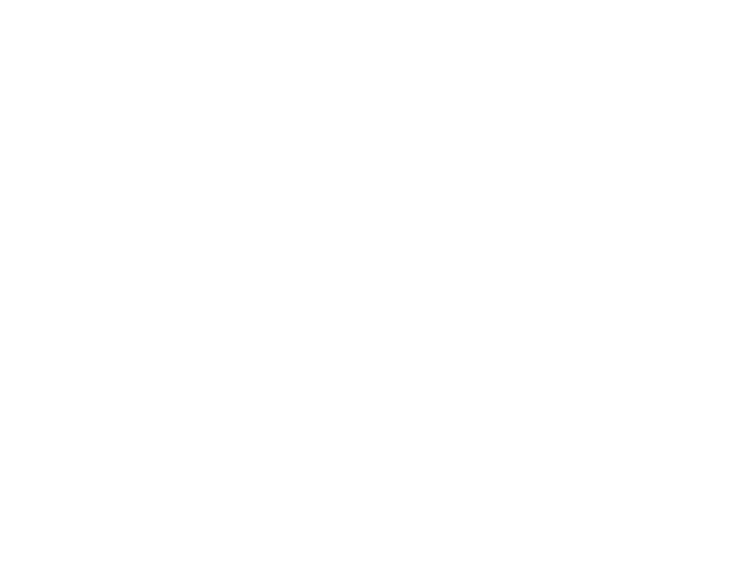

<IPython.core.display.Javascript object>


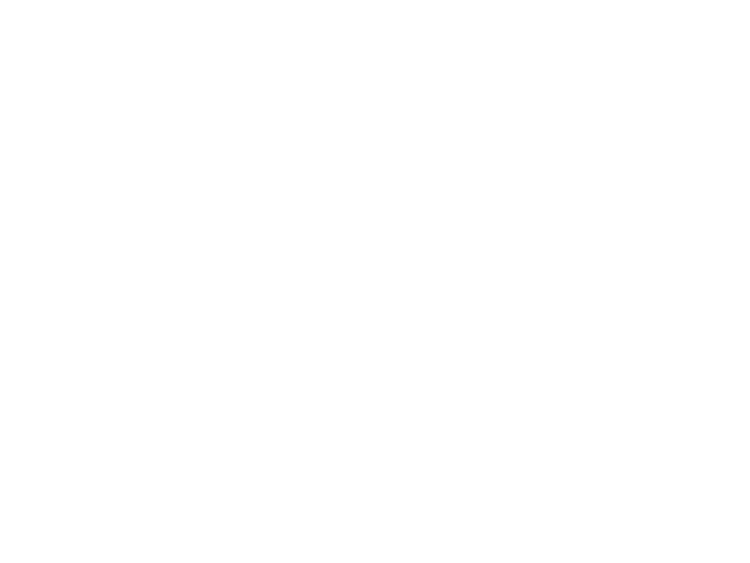

<IPython.core.display.Javascript object>


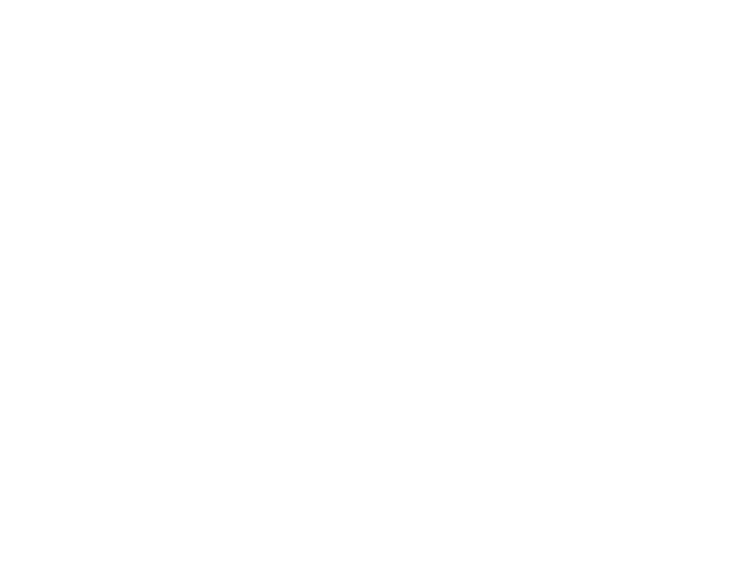

<IPython.core.display.Javascript object>


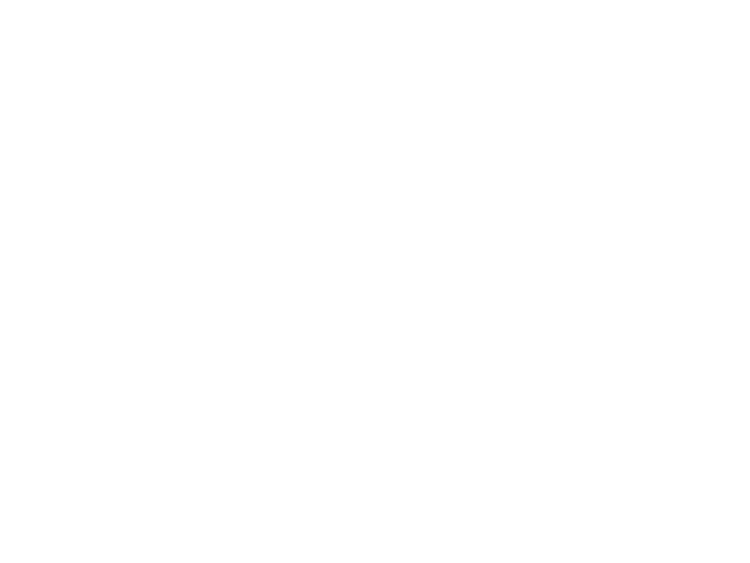

<IPython.core.display.Javascript object>


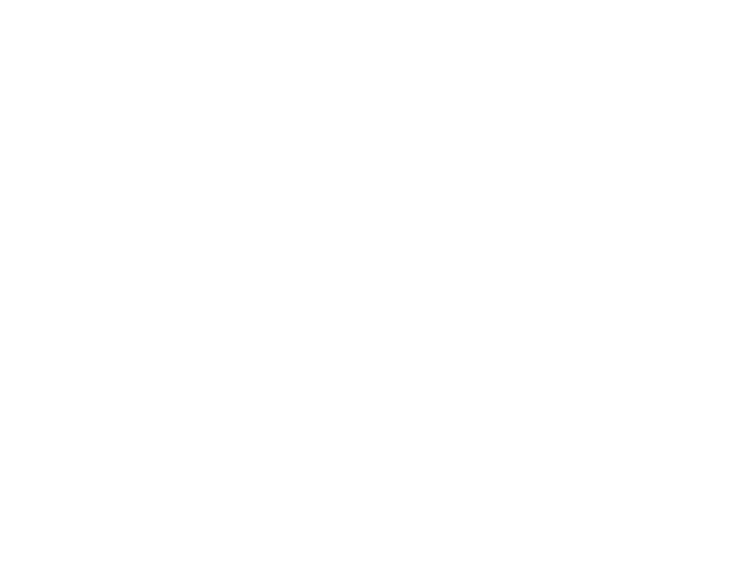

<IPython.core.display.Javascript object>


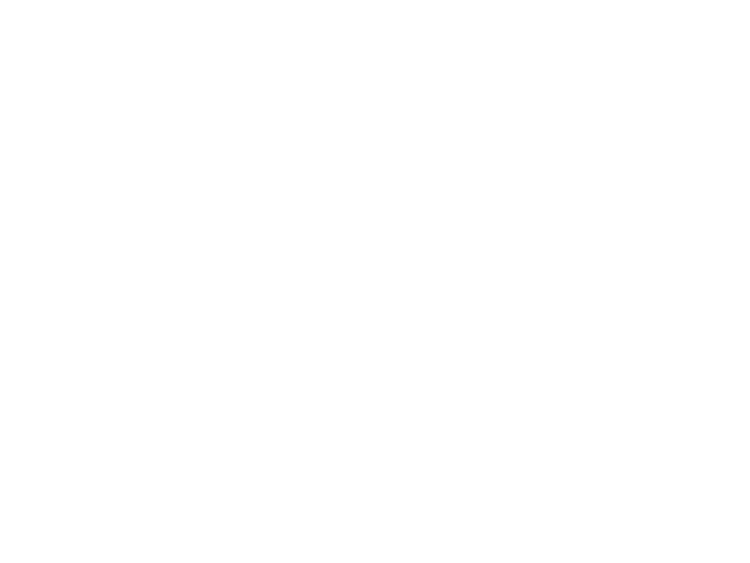

<IPython.core.display.Javascript object>


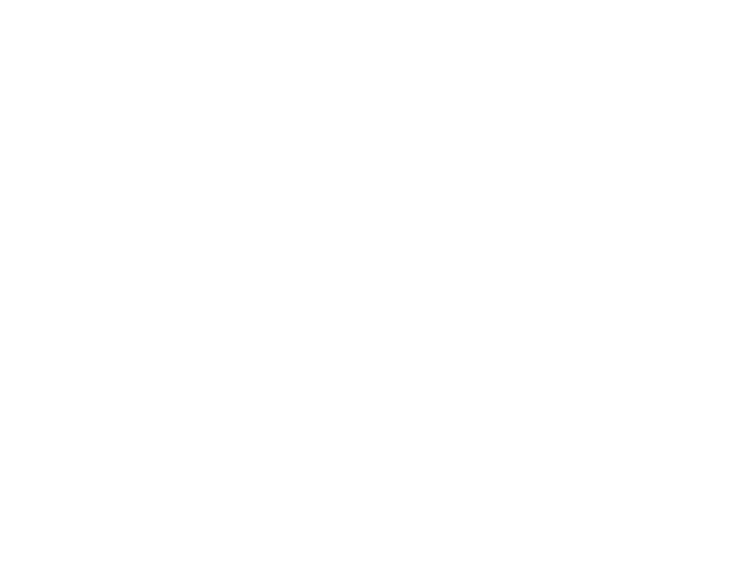

<IPython.core.display.Javascript object>


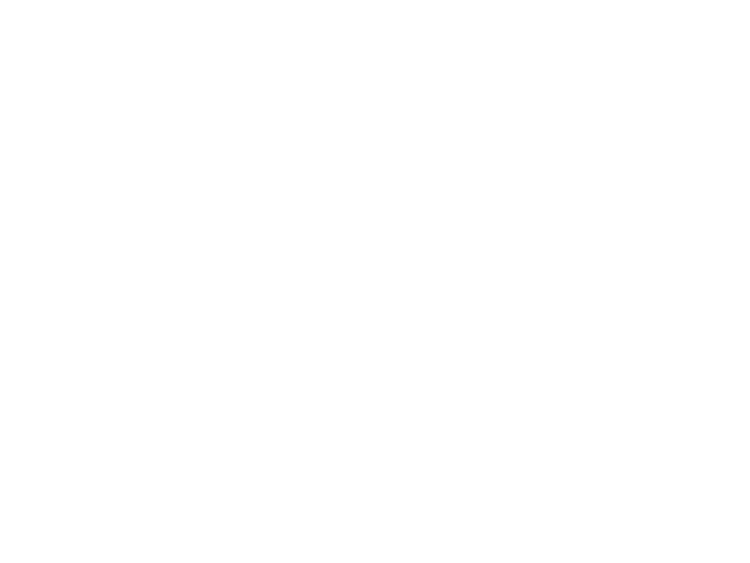

<IPython.core.display.Javascript object>


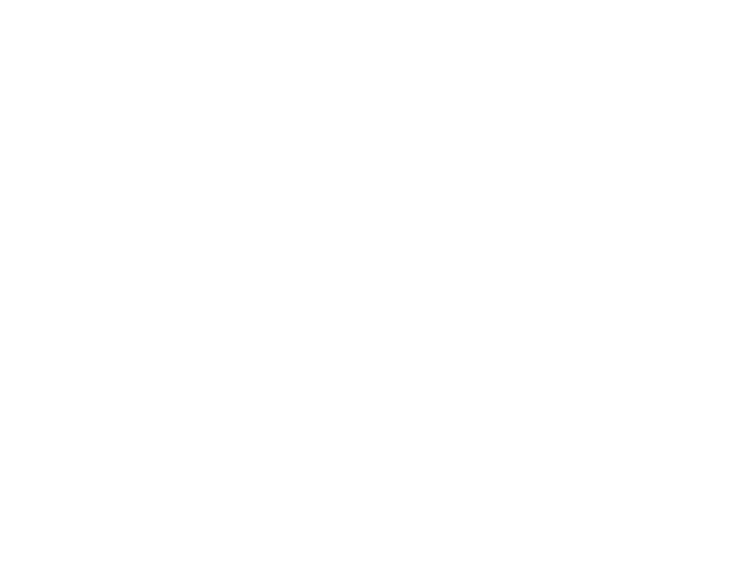

<IPython.core.display.Javascript object>


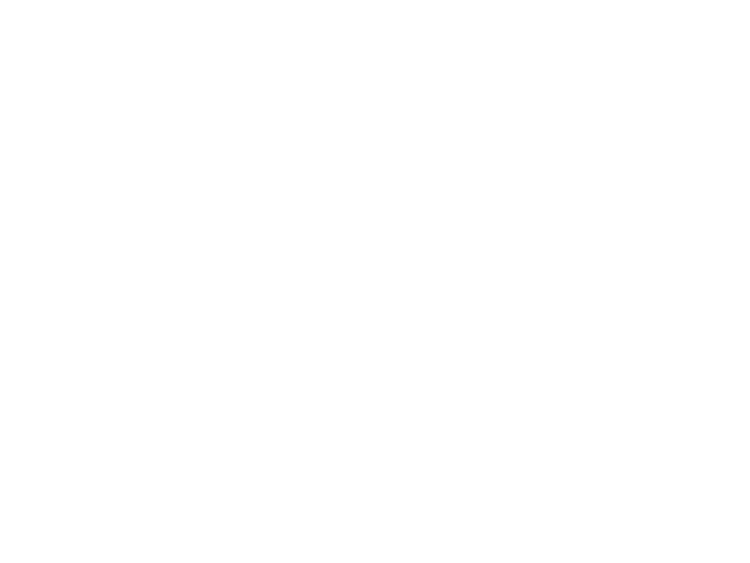

<IPython.core.display.Javascript object>


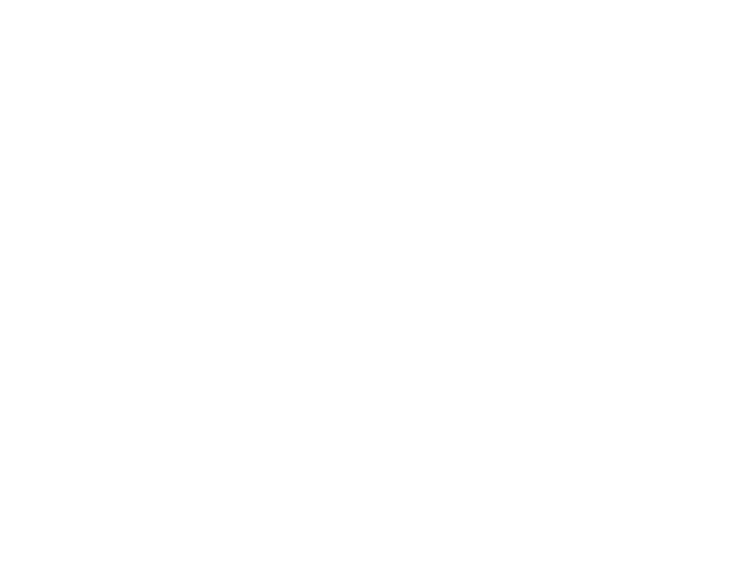

<IPython.core.display.Javascript object>


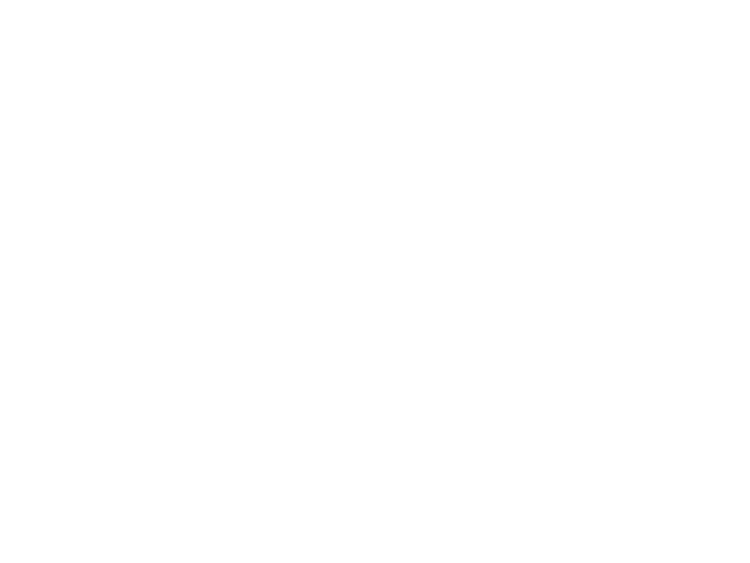

<IPython.core.display.Javascript object>


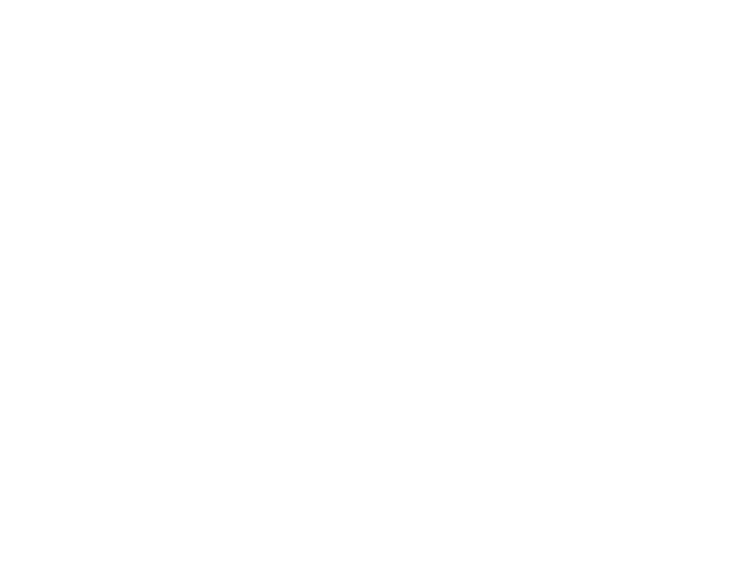

<IPython.core.display.Javascript object>


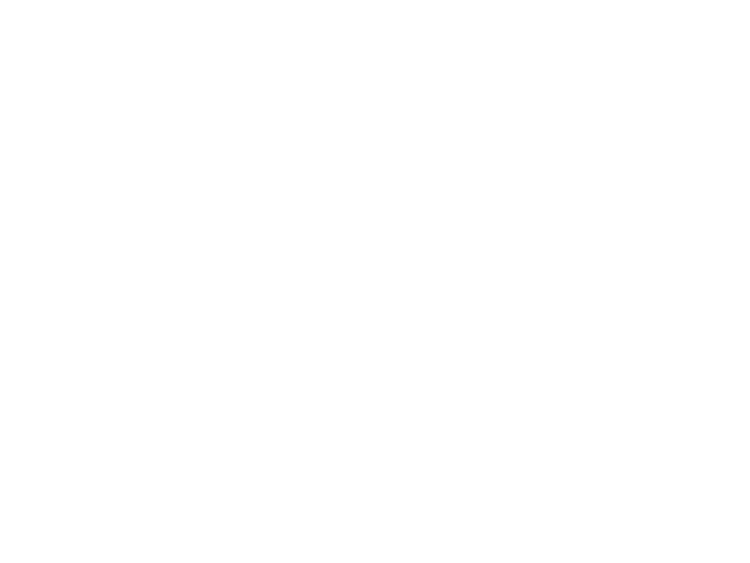

<IPython.core.display.Javascript object>


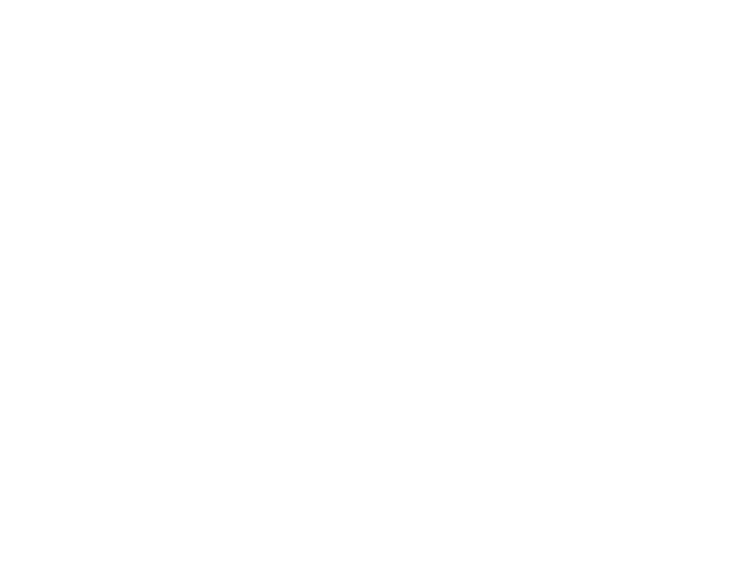

<IPython.core.display.Javascript object>


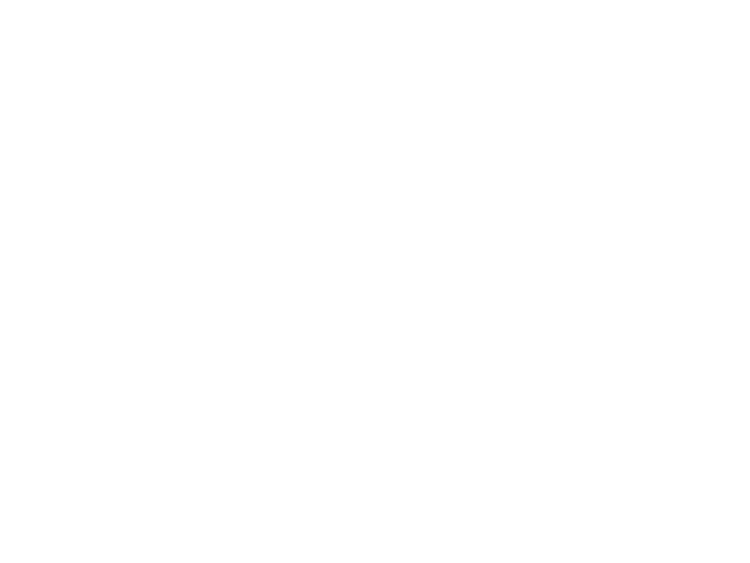

<IPython.core.display.Javascript object>


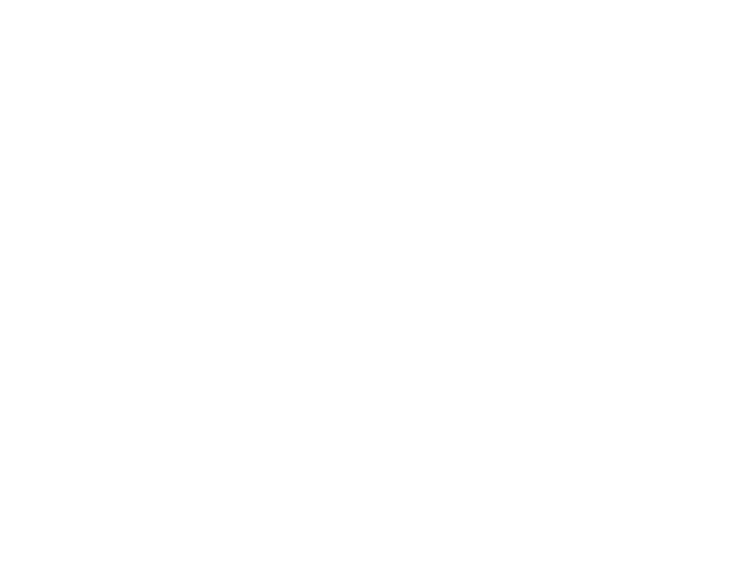

<IPython.core.display.Javascript object>


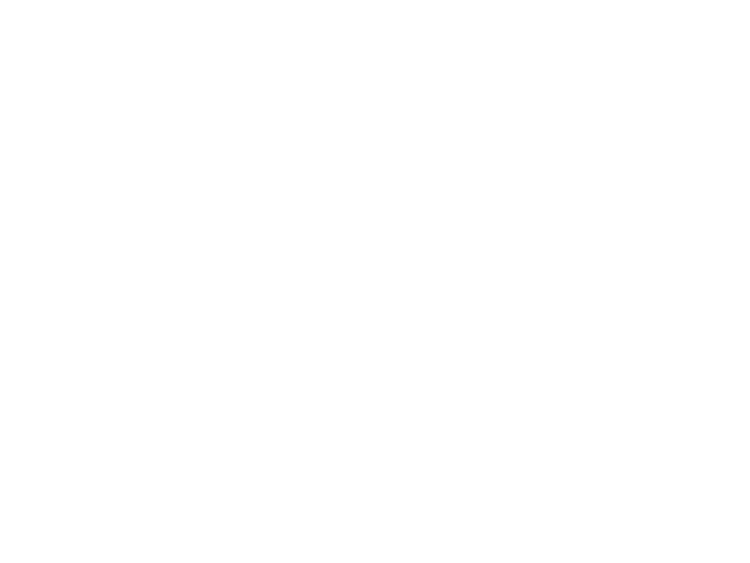

<IPython.core.display.Javascript object>


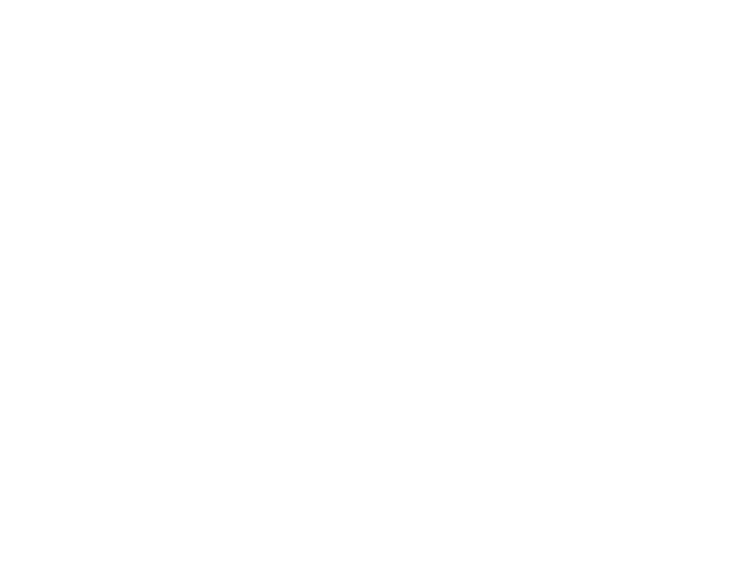

<IPython.core.display.Javascript object>


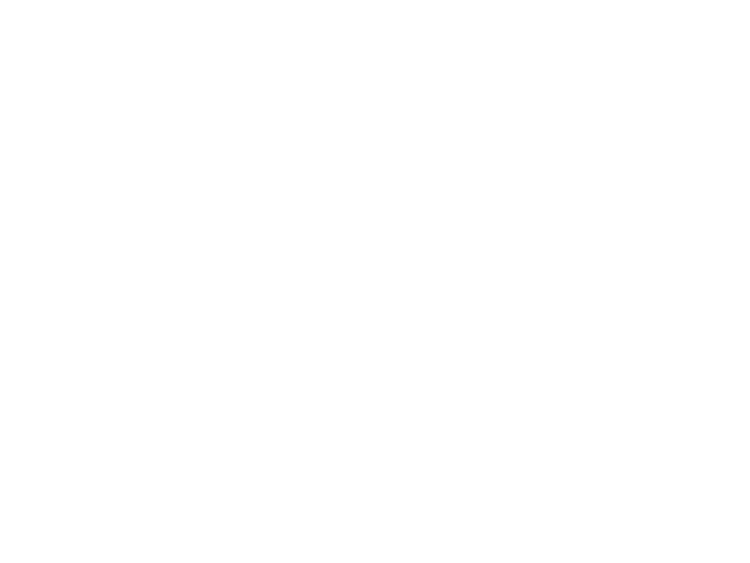

<IPython.core.display.Javascript object>


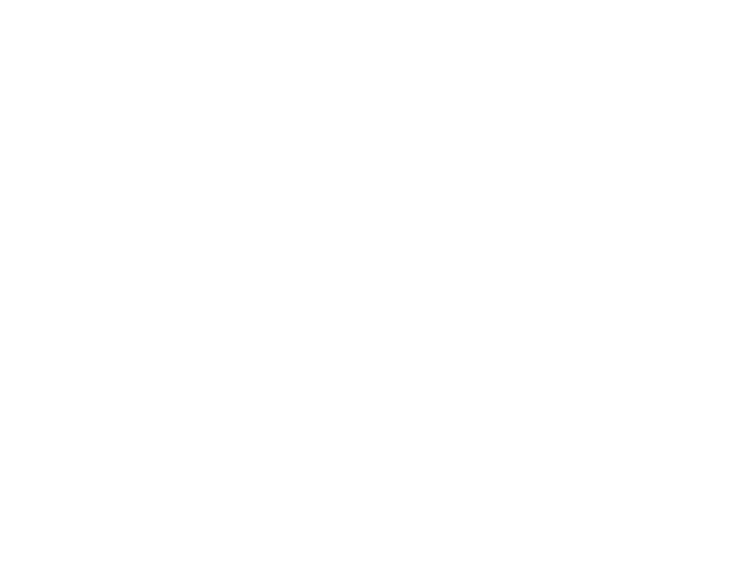

<IPython.core.display.Javascript object>


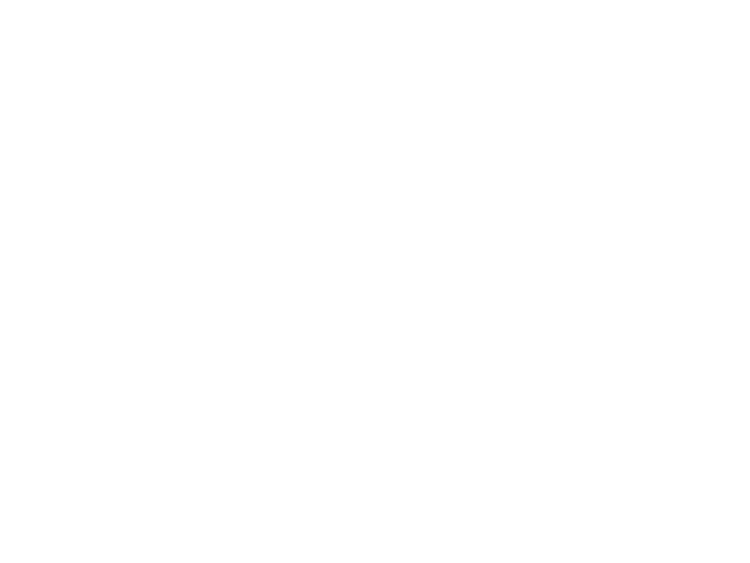

<IPython.core.display.Javascript object>


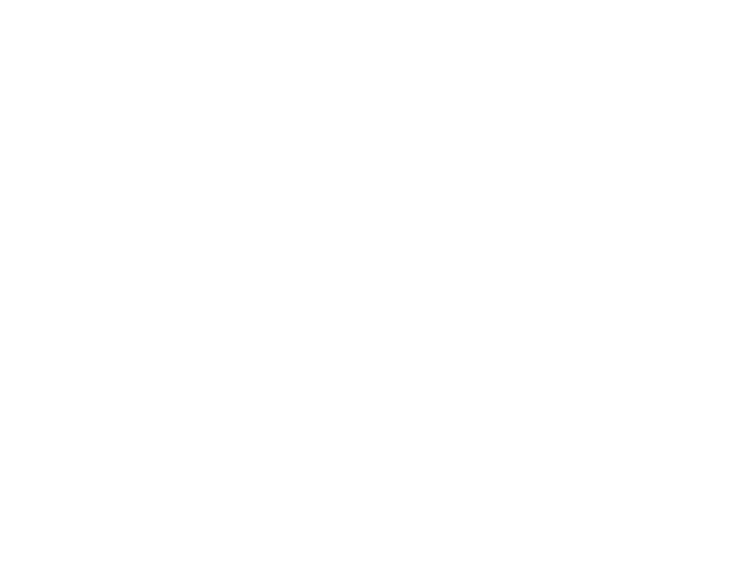

<IPython.core.display.Javascript object>


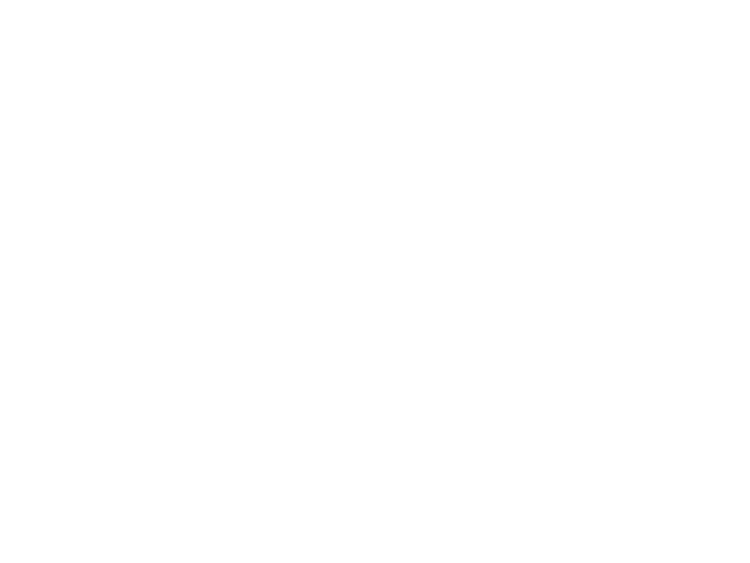

In [148]:
for i in range(30):
    Y  = np.abs(np.fft.fft(regionWisePickup_Jan_2016[i][0:4096]))
    # read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
    freq = np.abs(np.fft.fftfreq(4096, 1))
    n = len(freq)
    plt.figure(figsize = (8, 6))
    plt.plot(freq[:], Y[:])
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.title("Fourier Transformed Frequency and Amplitudes of Cluster Region "+str(i+1)+", for Jan 2016.")
    plt.show()
#Here, we are concern only about positive frequencies and ampllitudes. "np.fft.fftfreq(n, 1)" returns the frequency of sine 
#in a symmetric form, means there will be equal number of positive and negative sine wave frequencies. But we are concern only
#about positive ones.

Here, there is one peak at a frequency of 1/144 which is equivalent to 24 hrs. This peak is capturing full 24hrs pickups and since during hush hours the pickups are high so therefore peak of wave is also high at 1/144. Another peak is at frequency of 1/72 which is equivalent to 12 hrs. Now this peak is capturing information of the hush hours, so therefore this peak is the highest beside DC componet which we are noth considering, and so on. If we keep on going than frequency of 1/36 is equivalent to 6 hrs, similarly frequency of 1/18 is equivalent to 3 hrs and so on.<br><br>

Frequency means how many oscillations does wave completes in 1 Sec.<br><br>

Now if we see in the above plot, the first peak is a DC component, which captures the amplitude of wave which comes before the part of the wave shown in the above plot. Since, the wave which we have Fourier transformed is a repeating wave, so therefore, DC componets is capturing the information of the previous part of the wave, hence, we will not consider it's amplitude and frequency. We will start taking frequency and amplitudes from the second peak onwards.

In [149]:
amplitude_lists = []
frequency_lists = []
for i in range(30):
    ampli  = np.abs(np.fft.fft(regionWisePickup_Jan_2016[i][0:4096]))
    freq = np.abs(np.fft.fftfreq(4096, 1))
    ampli_indices = np.argsort(-ampli)[1:]        #it will return an array of indices for which corresponding amplitude values are sorted in reverse order.
    amplitude_values = []
    frequency_values = []
    for j in range(0, 9, 2):   #taking top five amplitudes and frequencies
        amplitude_values.append(ampli[ampli_indices[j]])
        frequency_values.append(freq[ampli_indices[j]])
    for k in range(4459):    #those top 5 frequencies and amplitudes are same for all the points in one cluster
        amplitude_lists.append(amplitude_values)
        frequency_lists.append(frequency_values) 

<b>Now we have built our all the features. We have finally now following 19 features in our data:</b>
1. <b>f_t_1:</b> Number of pickups that are happened previous t-1st 10min interval
2. <b>f_t_2:</b> Number of pickups that are happened previous t-2nd 10min interval
3. <b>f_t_3:</b> Number of pickups that are happened previous t-3rd 10min interval
4. <b>f_t_4:</b> Number of pickups that are happened previous t-4th 10min interval
5. <b>f_t_5:</b> Number of pickups that are happened previous t-5th 10min interval 
6. <b>Freq1:</b> Fourier Frequency corresponding to 1st highest amplitude
7. <b>Freq2:</b> Fourier Frequency corresponding to 2nd highest amplitude
8. <b>Freq3:</b> Fourier Frequency corresponding to 3rd highest amplitude
9. <b>Freq4:</b> Fourier Frequency corresponding to 4th highest amplitude
10. <b>Freq5:</b> Fourier Frequency corresponding to 5th highest amplitude
11. <b>Amp1:</b>  Amplitude corresponding to 1st highest fourier transformed wave.
12. <b>Amp2:</b>  Amplitude corresponding to 2nd highest fourier transformed wave.
13. <b>Amp3:</b>  Amplitude corresponding to 3rd highest fourier transformed wave.
14. <b>Amp4:</b>  Amplitude corresponding to 4th highest fourier transformed wave.
15. <b>Amp5:</b>  Amplitude corresponding to 5th highest fourier transformed wave.
16. <b>Latitude:</b> Latitude of Cluster center.
17. <b>Longitude:</b> Longitude of Cluster Center.
18. <b>WeekDay:</b> Day of week of pickup.
19. <b>WeightedAvg:</b>: Weighted Moving Average Prediction values.

## Data Preparation for regression models
Before we start predictions using the tree based regression models we take Jan 2016 pickup data and split it such that for every region we have 80% data in train and 20% in test, ordered date-wise for every region.

In [150]:
print("size of total train data :" +str(int(133770*0.8)))
print("size of total test data :" +str(int(133770*0.2)))

size of total train data :107016
size of total test data :26754


In [151]:
print("size of train data for one cluster:" +str(int(4459*0.8)))
print("size of total test data for one cluster:" +str(int(4459*0.2)))

size of train data for one cluster:3567
size of total test data for one cluster:891


In [152]:
train_previousFive_pickups  = [feat[i*4459:(4459*i+3567)] for i in range(30)]
test_previousFive_pickups  = [feat[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [153]:
train_fourier_frequencies = [frequency_lists[i*4459:(4459*i+3567)] for i in range(30)]
test_fourier_frequencies = [frequency_lists[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [154]:
train_fourier_amplitudes = [amplitude_lists[i*4459:(4459*i+3567)] for i in range(30)]
test_fourier_amplitudes = [amplitude_lists[(i*4459)+3567:(4459*(i+1))] for i in range(30)]

In [155]:
print("Train Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of training points = {}".format(len(train_previousFive_pickups), len(train_previousFive_pickups[0]), len(train_previousFive_pickups)*len(train_previousFive_pickups[0])))
print("Test Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of test points = {}".format(len(test_previousFive_pickups), len(test_previousFive_pickups[0]), len(test_previousFive_pickups)*len(test_previousFive_pickups[0])))

Train Data: Total number of clusters = 30. Number of points in each cluster = 3567. Total number of training points = 107010
Test Data: Total number of clusters = 30. Number of points in each cluster = 892. Total number of test points = 26760


In [156]:
#taking 80% data as train data from each cluster
train_lat = [i[:3567] for i in lat]
train_lon = [i[:3567] for i in lon]
train_weekDay = [i[:3567] for i in day_of_week]
train_weighted_avg = [i[:3567] for i in predicted_pickup_values_list]
train_TruePickups = [i[:3567] for i in TruePickups]

In [157]:
#taking 20% data as test data from each cluster
test_lat = [i[3567:] for i in lat]
test_lon = [i[3567:] for i in lon]
test_weekDay = [i[3567:] for i in day_of_week]
test_weighted_avg = [i[3567:] for i in predicted_pickup_values_list]
test_TruePickups = [i[3567:] for i in TruePickups]

In [158]:
# convert from lists of lists of list to lists of list
train_pickups = []
test_pickups = []
train_freq = []
test_freq = []
train_amp = []
test_amp = []
for i in range(30):
    train_pickups.extend(train_previousFive_pickups[i])
    test_pickups.extend(test_previousFive_pickups[i])
    train_freq.extend(train_fourier_frequencies[i])
    test_freq.extend(test_fourier_frequencies[i])
    train_amp.extend(train_fourier_amplitudes[i])
    test_amp.extend(test_fourier_amplitudes[i])

In [159]:
#stacking pickups,frequencies and amplitudes horizontally.
# a = [1,2,3,4,5]
# b = [6,7,8,9,10]
# c = [11,12,13,14,15]
# d = np.hstack((a, b, c))
# d = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

train_prevPickups_freq_amp = np.hstack((train_pickups, train_freq, train_amp))
test_prevPickups_freq_amp = np.hstack((test_pickups, test_freq, test_amp))

In [160]:
print("Number of data points in train data = {}. Number of columns till now = {}".format(len(train_prevPickups_freq_amp), len(train_prevPickups_freq_amp[0])))
print("Number of data points in test data = {}. Number of columns till now = {}".format(len(test_prevPickups_freq_amp), len(test_prevPickups_freq_amp[0])))

Number of data points in train data = 107010. Number of columns till now = 15
Number of data points in test data = 26760. Number of columns till now = 15


In [161]:
# converting lists of lists into single list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

train_flat_lat = sum(train_lat, [])
train_flat_lon = sum(train_lon, [])
train_flat_weekDay = sum(train_weekDay, [])
train_weighted_avg_flat = sum(train_weighted_avg, [])
train_TruePickups_flat = sum(train_TruePickups, [])

test_flat_lat = sum(test_lat, [])
test_flat_lon = sum(test_lon, [])
test_flat_weekDay = sum(test_weekDay, [])
test_weighted_avg_flat = sum(test_weighted_avg, [])
test_TruePickups_flat = sum(test_TruePickups, [])

In [162]:
#train dataframe
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1', 'freq1', 'freq2','freq3','freq4','freq5', 'Amp1', 'Amp2', 'Amp3', 'Amp4', 'Amp5']
Train_DF = pd.DataFrame(data = train_prevPickups_freq_amp, columns = columns)
Train_DF["Latitude"] = train_flat_lat
Train_DF["Longitude"] = train_flat_lon
Train_DF["WeekDay"] = train_flat_weekDay
Train_DF["WeightedAvg"] = train_weighted_avg_flat

In [163]:
#test dataframe
Test_DF = pd.DataFrame(data = test_prevPickups_freq_amp, columns = columns)
Test_DF["Latitude"] = test_flat_lat
Test_DF["Longitude"] = test_flat_lon
Test_DF["WeekDay"] = test_flat_weekDay
Test_DF["WeightedAvg"] = test_weighted_avg_flat

In [164]:
print("Shape of train data = "+str(Train_DF.shape))
print("Shape of test data = "+str(Test_DF.shape))

Shape of train data = (107010, 19)
Shape of test data = (26760, 19)


In [165]:
Train_DF.head()

ft_5   ft_4   ft_3   ft_2   ft_1     freq1     freq2     freq3     freq4  \
0   99.0  199.0  209.0  177.0  198.0  0.013916  0.012939  0.006836  0.000244   
1  199.0  209.0  177.0  198.0  211.0  0.013916  0.012939  0.006836  0.000244   
2  209.0  177.0  198.0  211.0  205.0  0.013916  0.012939  0.006836  0.000244   
3  177.0  198.0  211.0  205.0  186.0  0.013916  0.012939  0.006836  0.000244   
4  198.0  211.0  205.0  186.0  183.0  0.013916  0.012939  0.006836  0.000244   

      freq5         Amp1          Amp2          Amp3          Amp4  \
0  0.000732  87684.94906  49409.759255  41628.781089  37690.003896   
1  0.000732  87684.94906  49409.759255  41628.781089  37690.003896   
2  0.000732  87684.94906  49409.759255  41628.781089  37690.003896   
3  0.000732  87684.94906  49409.759255  41628.781089  37690.003896   
4  0.000732  87684.94906  49409.759255  41628.781089  37690.003896   

           Amp5   Latitude  Longitude  WeekDay  WeightedAvg  
0  37316.216449  40.760197   -73.9907        5          191  
1  37316.216449  40.760197   -73.9907        5          206  
2  37316.216449  40.760197   -73.9907        5          207  
3  37316.216449  40.760197   -73.9907        5          192  
4  37316.216449  40.760197   -73.9907        5          184

In [166]:
Test_DF.head()

ft_5   ft_4   ft_3   ft_2   ft_1     freq1     freq2     freq3     freq4  \
0  131.0  145.0  167.0  162.0  129.0  0.013916  0.012939  0.006836  0.000244   
1  145.0  167.0  162.0  129.0  133.0  0.013916  0.012939  0.006836  0.000244   
2  167.0  162.0  129.0  133.0  149.0  0.013916  0.012939  0.006836  0.000244   
3  162.0  129.0  133.0  149.0  118.0  0.013916  0.012939  0.006836  0.000244   
4  129.0  133.0  149.0  118.0  114.0  0.013916  0.012939  0.006836  0.000244   

      freq5         Amp1          Amp2          Amp3          Amp4  \
0  0.000732  87684.94906  49409.759255  41628.781089  37690.003896   
1  0.000732  87684.94906  49409.759255  41628.781089  37690.003896   
2  0.000732  87684.94906  49409.759255  41628.781089  37690.003896   
3  0.000732  87684.94906  49409.759255  41628.781089  37690.003896   
4  0.000732  87684.94906  49409.759255  41628.781089  37690.003896   

           Amp5   Latitude  Longitude  WeekDay  WeightedAvg  
0  37316.216449  40.760197   -73.9907        1          140  
1  37316.216449  40.760197   -73.9907        1          131  
2  37316.216449  40.760197   -73.9907        1          143  
3  37316.216449  40.760197   -73.9907        1          128  
4  37316.216449  40.760197   -73.9907        1          115

## Linear Regression

In [167]:
def lin_regression(train_data, train_true, test_data, test_true):
    
    #standardizing the data
    train_std = StandardScaler().fit_transform(train_data)
    test_std = StandardScaler().fit_transform(test_data)
    
    #hyper-paramater tuning
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
    values = [10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
    hyper_parameter = {"alpha": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_std, train_true)
    alpha = best_parameter.best_params_["alpha"]
    
    #applying linear regression with best hyper-parameter
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
    clf.fit(train_std, train_true)
    train_pred = clf.predict(train_std)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_std)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

## Random Forest Regressor

In [168]:
def randomFor(train_data, train_true, test_data, test_true):
    
    #hyper-paramater tuning
    values = [10, 40, 80, 150, 600, 800]
    clf = RandomForestRegressor(n_jobs = -1)
    hyper_parameter = {"n_estimators": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    
    #applying random forest with best hyper-parameter
    clf = RandomForestRegressor(n_estimators = estimators, n_jobs = -1)
    clf.fit(train_data, train_true)
    train_pred = clf.predict(train_data)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_data)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

## XGBoost Regressor

In [169]:
def xgboost_reg(train_data, train_true, test_data, test_true):
    #hyper-parameter tuning
    hyper_parameter = {"max_depth":[1, 2, 3, 4], "n_estimators":[40, 80, 150, 600]}
    clf = xgb.XGBRegressor()
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    depth = best_parameter.best_params_["max_depth"]
    
    #applying xgboost regressor with best hyper-parameter
    clf = xgb.XGBRegressor(max_depth = depth, n_estimators = estimators)
    clf.fit(train_data, train_true)
    train_pred = clf.predict(train_data)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_data)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

In [170]:
trainMAPE_lr, trainMSE_lr, testMAPE_lr, testMSE_lr = lin_regression(Train_DF, train_TruePickups_flat, Test_DF, test_TruePickups_flat)
trainMAPE_rf, trainMSE_rf, testMAPE_rf, testMSE_rf = randomFor(Train_DF, train_TruePickups_flat, Test_DF, test_TruePickups_flat)
trainMAPE_xgb, trainMSE_xgb, testMAPE_xgb, testMSE_xgb = xgboost_reg(Train_DF, train_TruePickups_flat, Test_DF, test_TruePickups_flat)

# 6. Model Comparison

In [171]:
error_table_regressions = pd.DataFrame(columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"])

error_table_regressions = error_table_regressions.append(pd.DataFrame([["Linear Regression", trainMAPE_lr*100, trainMSE_lr, testMAPE_lr*100, testMSE_lr ]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions = error_table_regressions.append(pd.DataFrame([["Random Forest Regression", trainMAPE_rf*100, trainMSE_rf, testMAPE_rf*100, testMSE_rf]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions = error_table_regressions.append(pd.DataFrame([["XGBoost Regressor", trainMAPE_xgb*100, trainMSE_xgb, testMAPE_xgb*100, testMSE_xgb]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions.reset_index(drop = True, inplace = True)

In [172]:
error_table_regressions

Model  TrainMAPE(%)    TrainMSE  TestMAPE(%)     TestMSE
0         Linear Regression     13.128351  300.944649    17.477162  302.501919
1  Random Forest Regression      4.932131   52.550266    13.657305  251.494172
2         XGBoost Regressor     12.719888  256.669781    13.296094  220.545571

### From the above result we have following observations:
* <b>1. The difference between train error and test error of random forest regressor is high, which clearly shows that random forest regressor is overfitting. Therefore, we are discarding random forest regressor.</b>
* <b>2. The best model with lowest train and test error is XGBoost Regressor.</b>

In [173]:
Final_Table = pd.DataFrame(columns = ["Model", "Mean_Absolute_Per_Error(%)"])

Final_Table = Final_Table.append(pd.DataFrame([["Simple Moving Average Ratios", mape1*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))
Final_Table = Final_Table.append(pd.DataFrame([["Simple Moving Average Predictions", mape2*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))
Final_Table = Final_Table.append(pd.DataFrame([["Weighted Moving Average Ratios", mape3*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))
Final_Table = Final_Table.append(pd.DataFrame([["Weighted Moving Average Predictions", mape4*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))
Final_Table = Final_Table.append(pd.DataFrame([["Exponential Weighted Moving Average Ratios", mape5*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))
Final_Table = Final_Table.append(pd.DataFrame([["Exponential Weighted Moving Average Predictions", mape6*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))
Final_Table = Final_Table.append(pd.DataFrame([["Linear Regression", testMAPE_lr*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))
Final_Table = Final_Table.append(pd.DataFrame([["XGBoost Regressor", testMAPE_xgb*100]], columns = ["Model", "Mean_Absolute_Per_Error(%)"]))

Final_Table.reset_index(drop = True, inplace = True)

<IPython.core.display.Javascript object>


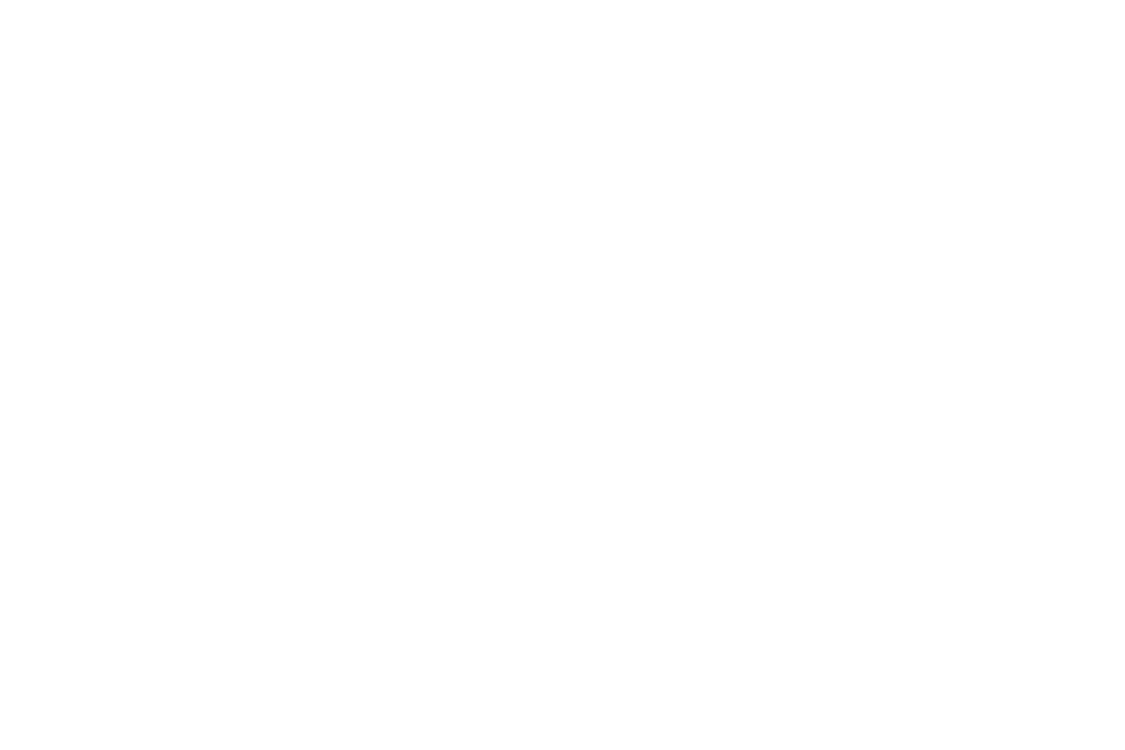

In [174]:
ax = Final_Table.plot(x = "Model", kind = "bar", figsize = (12, 8), grid = True, fontsize = 15)
ax.set_title("Test MAPE of all Models", fontsize = 25)
ax.set_ylabel("Mean Absolute Percentage Error(%)", fontsize = 15)

for i in ax.patches:   #ax.patches is an array which gives x position, y position, width of a bar graphs.
    ax.text(i.get_x()-.05, i.get_height()+0.19, str(round(i.get_height(), 2))+'%', fontsize=14, color='black')
#     ax.text(x, y, annotate_text, font_size, color)
plt.show()

In [175]:
Final_Table.style.highlight_min(axis=0)